# Notebook for the parameters optimization for cell composition change analysis with milo

- **Developed by:** Anna Maguza
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 31st March 2022

### Import packages

In [1]:
import scanpy as sc
import numpy as np

In [2]:
import matplotlib.pyplot as plt

In [3]:
import milopy
import milopy.core as milo 
import milopy.plot as milopl 
import milopy.utils    

### Define some functions

In [4]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

#### Setup Cells

In [5]:
%matplotlib inline

In [6]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


#### Setup Cells

In [7]:
%matplotlib inline

In [8]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.3.5 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


#### Upload Data

In [9]:
input_data = '/Users/anna.maguza/Desktop/Data/COPD_project/Marburg_All_ctl230321_leiden_states.raw.h5ad'
output_data = '/Users/anna.maguza/Desktop/Data/COPD_project/Marburg_All_ctl230321_leiden_states_output.h5ad'

In [10]:
adata = sc.read_h5ad(input_data)

In [11]:
# Merge column donor and column group into new column sample 
adata.obs["sample"] = adata.obs["donor"].astype(str) + "_" + adata.obs["group"].astype(str)

In [12]:
adata_raw = adata.copy()

In [13]:
X_is_raw(adata)

True

# Parameters optimization

In [14]:
adata = adata_raw.copy()

In [15]:
# Filter only healthy_ctrl and COPD_iav cells as they supposed to have the bigger variability
adata = adata[adata.obs['group'].isin(['healthy_ctrl', 'copd_iav'])]

In [16]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)


In [17]:
#Tutorial-based parameters

# Adjust the number of neighbors and PCA dimensions
k = 30
d = 50

# Re-run the analysis with the new parameters
sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)
milo.make_nhoods(adata, prop=0.1)
milo.count_nhoods(adata, sample_col="sample")
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes
milo.DA_nhoods(adata, design="~stage_continuous")

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:18)


/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [18]:
adata.uns["nhood_adata"].obs

index_cell  kth_distance     logFC    logCPM         F  \
0     104170-ST07_CSE_CTRL-V1    566.495972 -1.061547  8.402101  0.377996   
1      15014-ST07_CSE_CTRL-V1    636.498657 -1.351569  7.837653  0.802904   
2     752306-ST07_CSE_CTRL-V1    620.585022 -0.926430  8.355422  0.301760   
3      50854-ST07_CSE_CTRL-V1    905.321411 -3.639098  8.263828  3.950160   
4     411413-ST07_CSE_CTRL-V1    980.117493 -2.585590  7.903222  2.724729   
...                       ...           ...       ...       ...       ...   
4634    10496296-CSE03_IAV-V6    139.875259 -0.178659  8.459788  0.011303   
4635     4144207-CSE03_IAV-V6    152.504257 -0.601485  7.935111  0.176097   
4636     2097861-CSE03_IAV-V6    141.580734  0.365700  7.970825  0.066845   
4637     4720207-CSE03_IAV-V6    131.512527 -0.032534  7.911777  0.000530   
4638     8274833-CSE03_IAV-V6    122.164085  0.769618  8.017403  0.287129   

        PValue       FDR  SpatialFDR  
0     0.539073  0.875617    0.999511  
1     0.370836  0.777695    0.999511  
2     0.583128  0.894464    0.999511  
3     0.047638  0.270492    0.600647  
4     0.099693  0.442115    0.873443  
...        ...       ...         ...  
4634  0.915390  0.994235    0.999511  
4635  0.674998  0.932772    0.999511  
4636  0.796135  0.969995    0.999511  
4637  0.981638  0.995058    0.999511  
4638  0.592395  0.897785    0.999511  

[4639 rows x 8 columns]

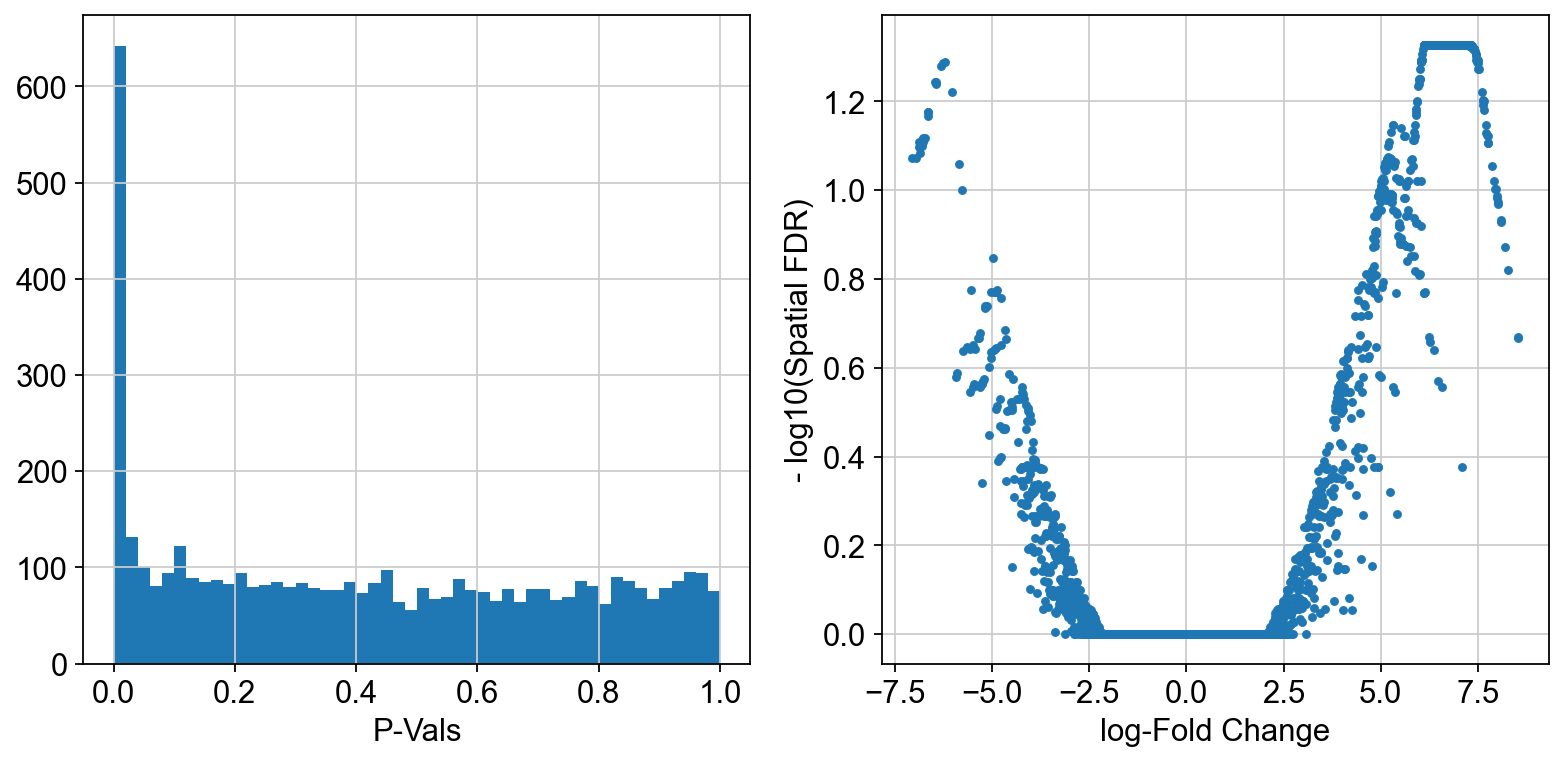

In [19]:
# Plot p-value histogram and Volcano plot with log-Fold Change (x-axis) against -log10(Spatial FDR) (y-axis). 
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [20]:
# Calculate how much cells pass the threshold FDR < 0.05 & p-value < 0.05 & logFC > 0.5
adata.uns["nhood_adata"].obs[(adata.uns["nhood_adata"].obs.SpatialFDR < 0.1) & (adata.uns["nhood_adata"].obs.PValue < 0.05) & (adata.uns["nhood_adata"].obs.logFC > 0.5)].shape[0]

374

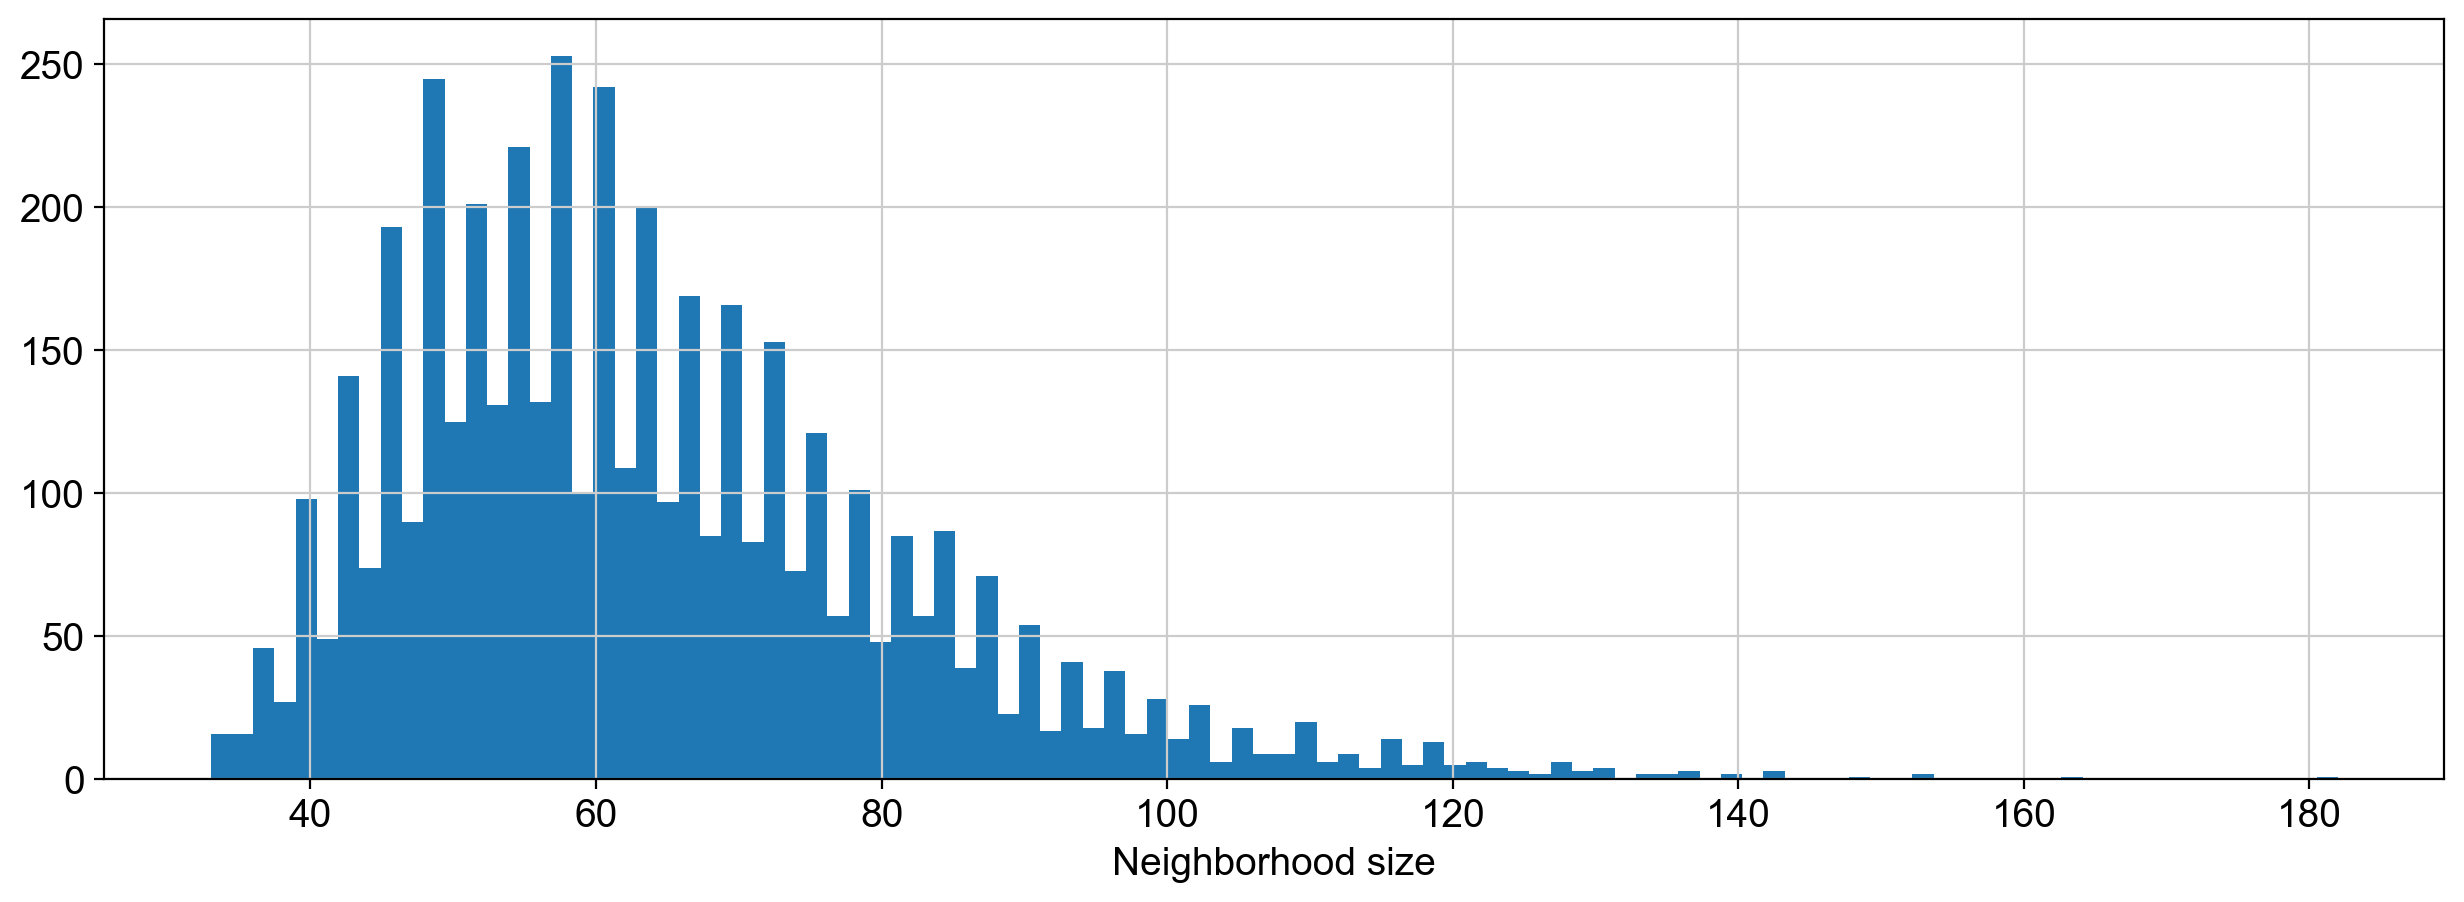

In [21]:
# Plot Neighborhood size distribution
sc.set_figure_params(figsize=(15, 5),dpi=100)
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)
plt.xlabel("Neighborhood size")
plt.show()

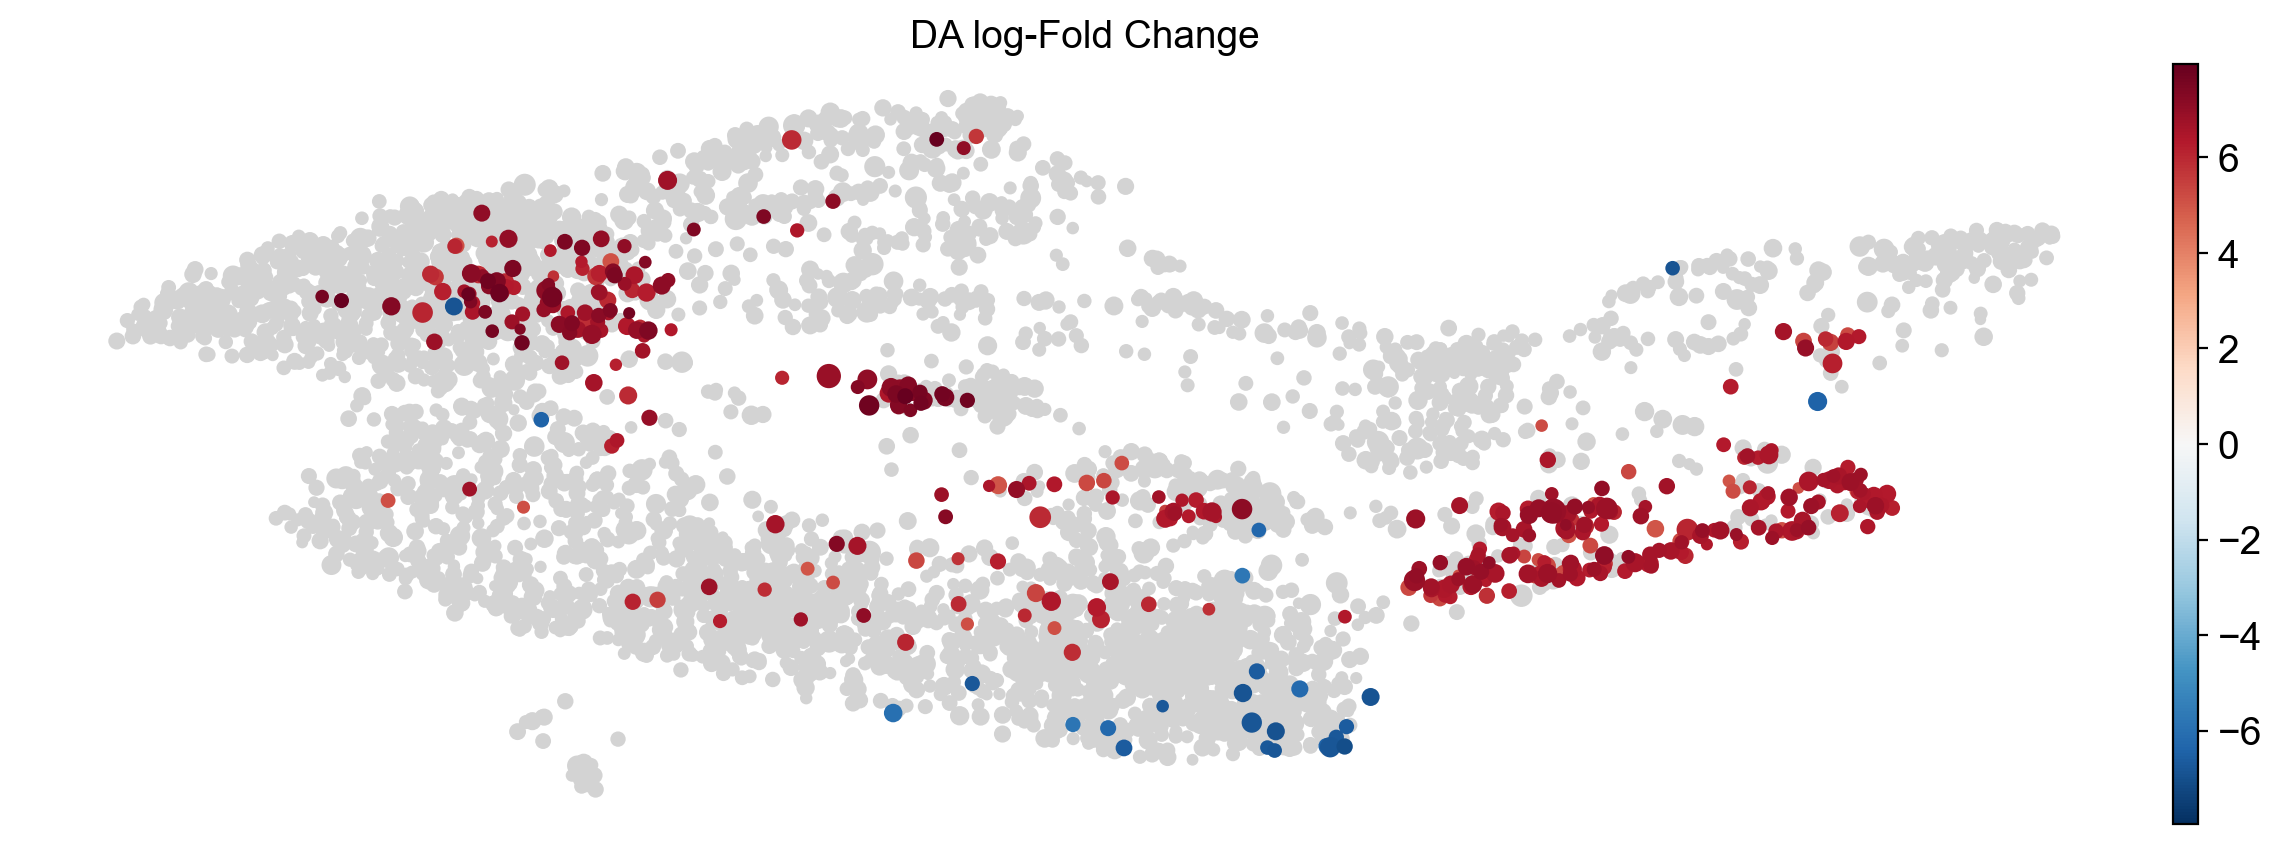

In [22]:
# Plot embedding with neighborhood graph

milopy.utils.build_nhood_graph(adata)

alpha=0.1
min_size=2
min_logFC: float = 0
plot_edges: bool = False
title: str = "DA log-Fold Change"

nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan

# Plotting order - extreme logFC on top
nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(),
                        "abs_logFC"] = np.nan
ordered = nhood_adata.obs.sort_values(
        'abs_logFC', na_position='first').index
nhood_adata = nhood_adata[ordered]

vmax = np.max([nhood_adata.obs["graph_color"].max(),
                  abs(nhood_adata.obs["graph_color"].min())])
vmin = - vmax

sc.pl.embedding(nhood_adata, "X_milo_graph", color="graph_color", cmap="RdBu_r", title=title, vmax=vmax, vmin=vmin,frameon=False, sort_order=False, 
edges=plot_edges, neighbors_key="nhood", size=adata.uns["nhood_adata"].obs["Nhood_size"]*min_size)

In [23]:
nhood_adata.obs

index_cell  kth_distance     logFC    logCPM         F  \
0     104170-ST07_CSE_CTRL-V1    566.495972 -1.061547  8.402101  0.377996   
1      15014-ST07_CSE_CTRL-V1    636.498657 -1.351569  7.837653  0.802904   
2     752306-ST07_CSE_CTRL-V1    620.585022 -0.926430  8.355422  0.301760   
3      50854-ST07_CSE_CTRL-V1    905.321411 -3.639098  8.263828  3.950160   
4     411413-ST07_CSE_CTRL-V1    980.117493 -2.585590  7.903222  2.724729   
...                       ...           ...       ...       ...       ...   
3196     5322281-CHE01_IAV-V3    334.158295  7.767409  8.989738  9.570795   
3218    13420842-CHE01_IAV-V3    403.137634  7.859794  9.070017  9.190633   
3334    11214730-CHE01_IAV-V3    269.754639  7.909495  9.112771  9.000271   
3215    12711262-CHE01_IAV-V3    475.376953  7.948769  9.147175  8.840654   
3420     1037983-CHE01_IAV-V3    210.784042  7.952023  9.151365  8.830841   

        PValue       FDR  SpatialFDR  Nhood_size  graph_color  abs_logFC  
0     0.539073  0.875617    0.999511        59.0          NaN        NaN  
1     0.370836  0.777695    0.999511        36.0          NaN        NaN  
2     0.583128  0.894464    0.999511        64.0          NaN        NaN  
3     0.047638  0.270492    0.600647        52.0          NaN        NaN  
4     0.099693  0.442115    0.873443        39.0          NaN        NaN  
...        ...       ...         ...         ...          ...        ...  
3196  0.002137  0.029153    0.078167        74.0     7.767409   7.767409  
3218  0.002614  0.032505    0.088066        78.0     7.859794   7.859794  
3334  0.002894  0.035049    0.095454        76.0     7.909495   7.909495  
3215  0.003151  0.036912    0.099140        77.0     7.948769   7.948769  
3420  0.003168  0.036939    0.099140        83.0     7.952023   7.952023  

[4639 rows x 11 columns]

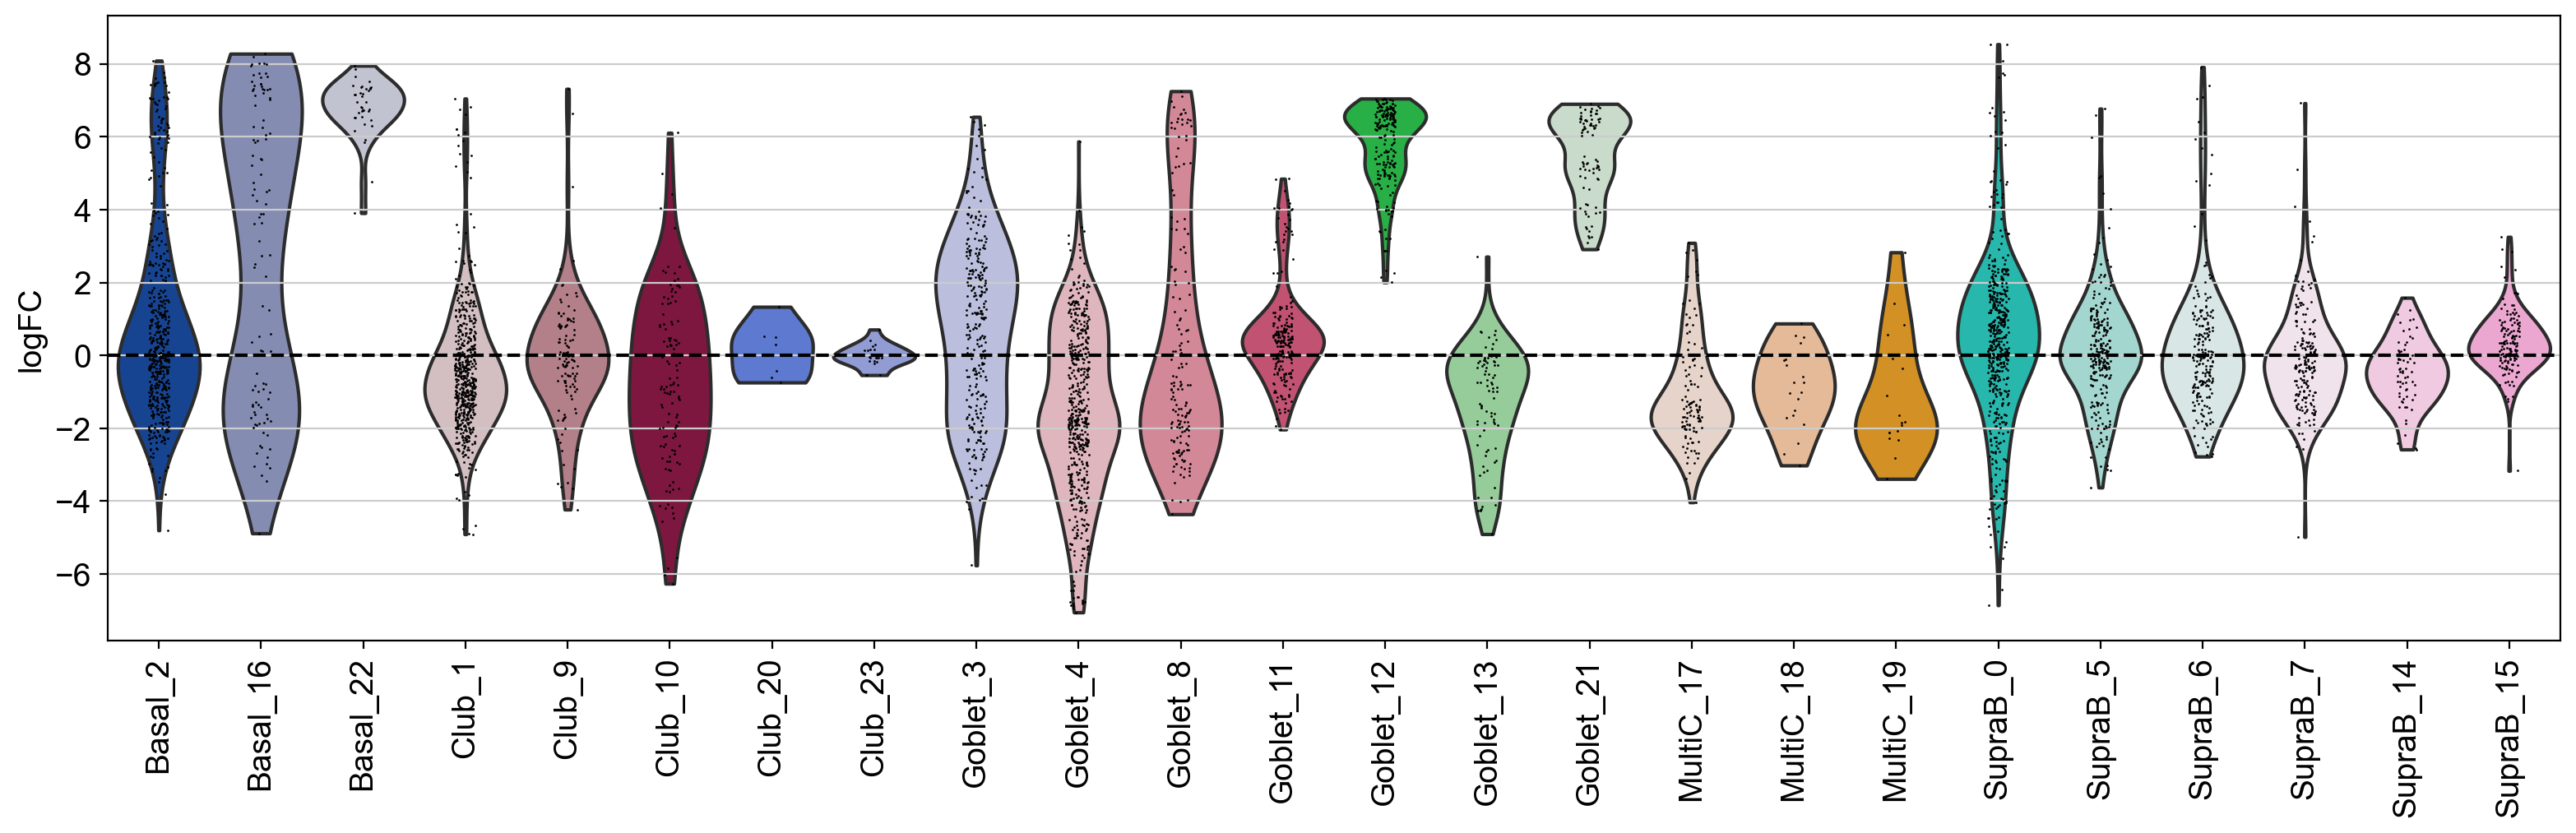

In [24]:
# Plot violin plots for differential abundance results by cell type
sc.set_figure_params(figsize=(15, 5),dpi=100)
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## Parameters change 1

In [25]:
adata = adata_raw.copy()

In [26]:
# Filter only healthy_ctrl and COPD_iav cells as they supposed to have the bigger variability
adata = adata[adata.obs['group'].isin(['healthy_ctrl', 'copd_iav'])]

In [27]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:20)


In [28]:
#Reducing the number of neighbors and PCA dimensions

# Adjust the number of neighbors and PCA dimensions
k = 20
d = 40

# Re-run the analysis with the new parameters
sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)
milo.make_nhoods(adata, prop=0.1)
milo.count_nhoods(adata, sample_col="sample")
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes
milo.DA_nhoods(adata, design="~stage_continuous")

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [29]:
adata.uns["nhood_adata"].obs

index_cell  kth_distance     logFC    logCPM         F  \
0     180867-ST07_CSE_CTRL-V1   1761.346191 -3.890512  8.209276  4.399684   
1     518211-ST07_CSE_CTRL-V1    978.467590 -1.915484  8.180935  1.323137   
2     535058-ST07_CSE_CTRL-V1    480.342651 -1.283992  8.092492  0.633796   
3     104170-ST07_CSE_CTRL-V1    503.982208 -1.521059  8.769097  0.664416   
4     367551-ST07_CSE_CTRL-V1    707.739197 -2.003637  8.395377  1.399248   
...                       ...           ...       ...       ...       ...   
4704    10496296-CSE03_IAV-V6    125.548866  0.087892  8.734730  0.002469   
4705     4144207-CSE03_IAV-V6    144.741379 -0.241168  8.094196  0.023547   
4706     2097861-CSE03_IAV-V6    130.041626  0.590916  8.309918  0.145143   
4707    12536461-CSE03_IAV-V6     93.276131  1.693958  8.442276  1.094782   
4708     8274833-CSE03_IAV-V6    112.189857  0.800392  8.318213  0.264992   

        PValue       FDR  SpatialFDR  
0     0.035951  0.226754    0.504156  
1     0.250036  0.676601    0.997961  
2     0.425971  0.800796    0.997961  
3     0.415010  0.791848    0.997961  
4     0.236856  0.665426    0.997961  
...        ...       ...         ...  
4704  0.960372  0.993983    0.997961  
4705  0.878044  0.976381    0.997961  
4706  0.703223  0.928651    0.997961  
4707  0.295420  0.708225    0.997961  
4708  0.606714  0.892200    0.997961  

[4709 rows x 8 columns]

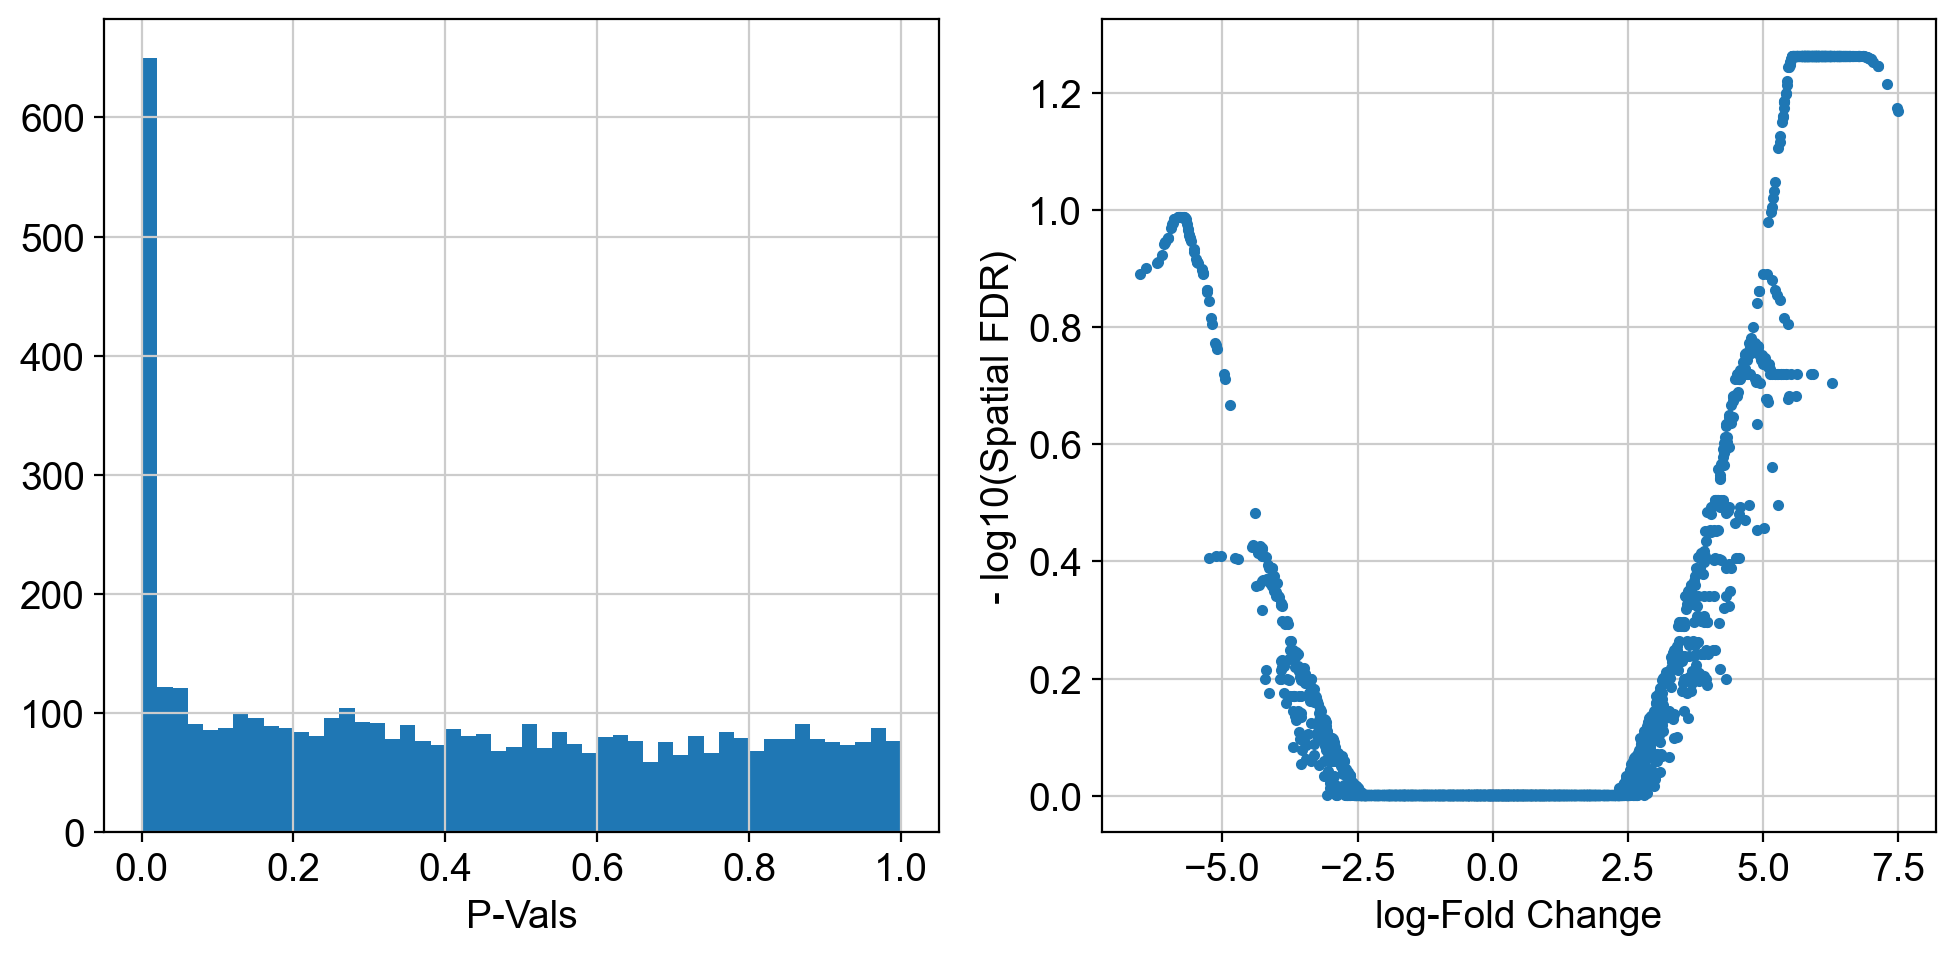

In [30]:
# Plot p-value histogram and Volcano plot with log-Fold Change (x-axis) against -log10(Spatial FDR) (y-axis). 
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [32]:
# Calculate how much cells pass the threshold FDR < 0.05 & p-value < 0.05 & logFC > 0.5
adata.uns["nhood_adata"].obs[(adata.uns["nhood_adata"].obs.SpatialFDR < 0.1) & (adata.uns["nhood_adata"].obs.PValue < 0.05) & (adata.uns["nhood_adata"].obs.logFC > 0.5)].shape[0]

417

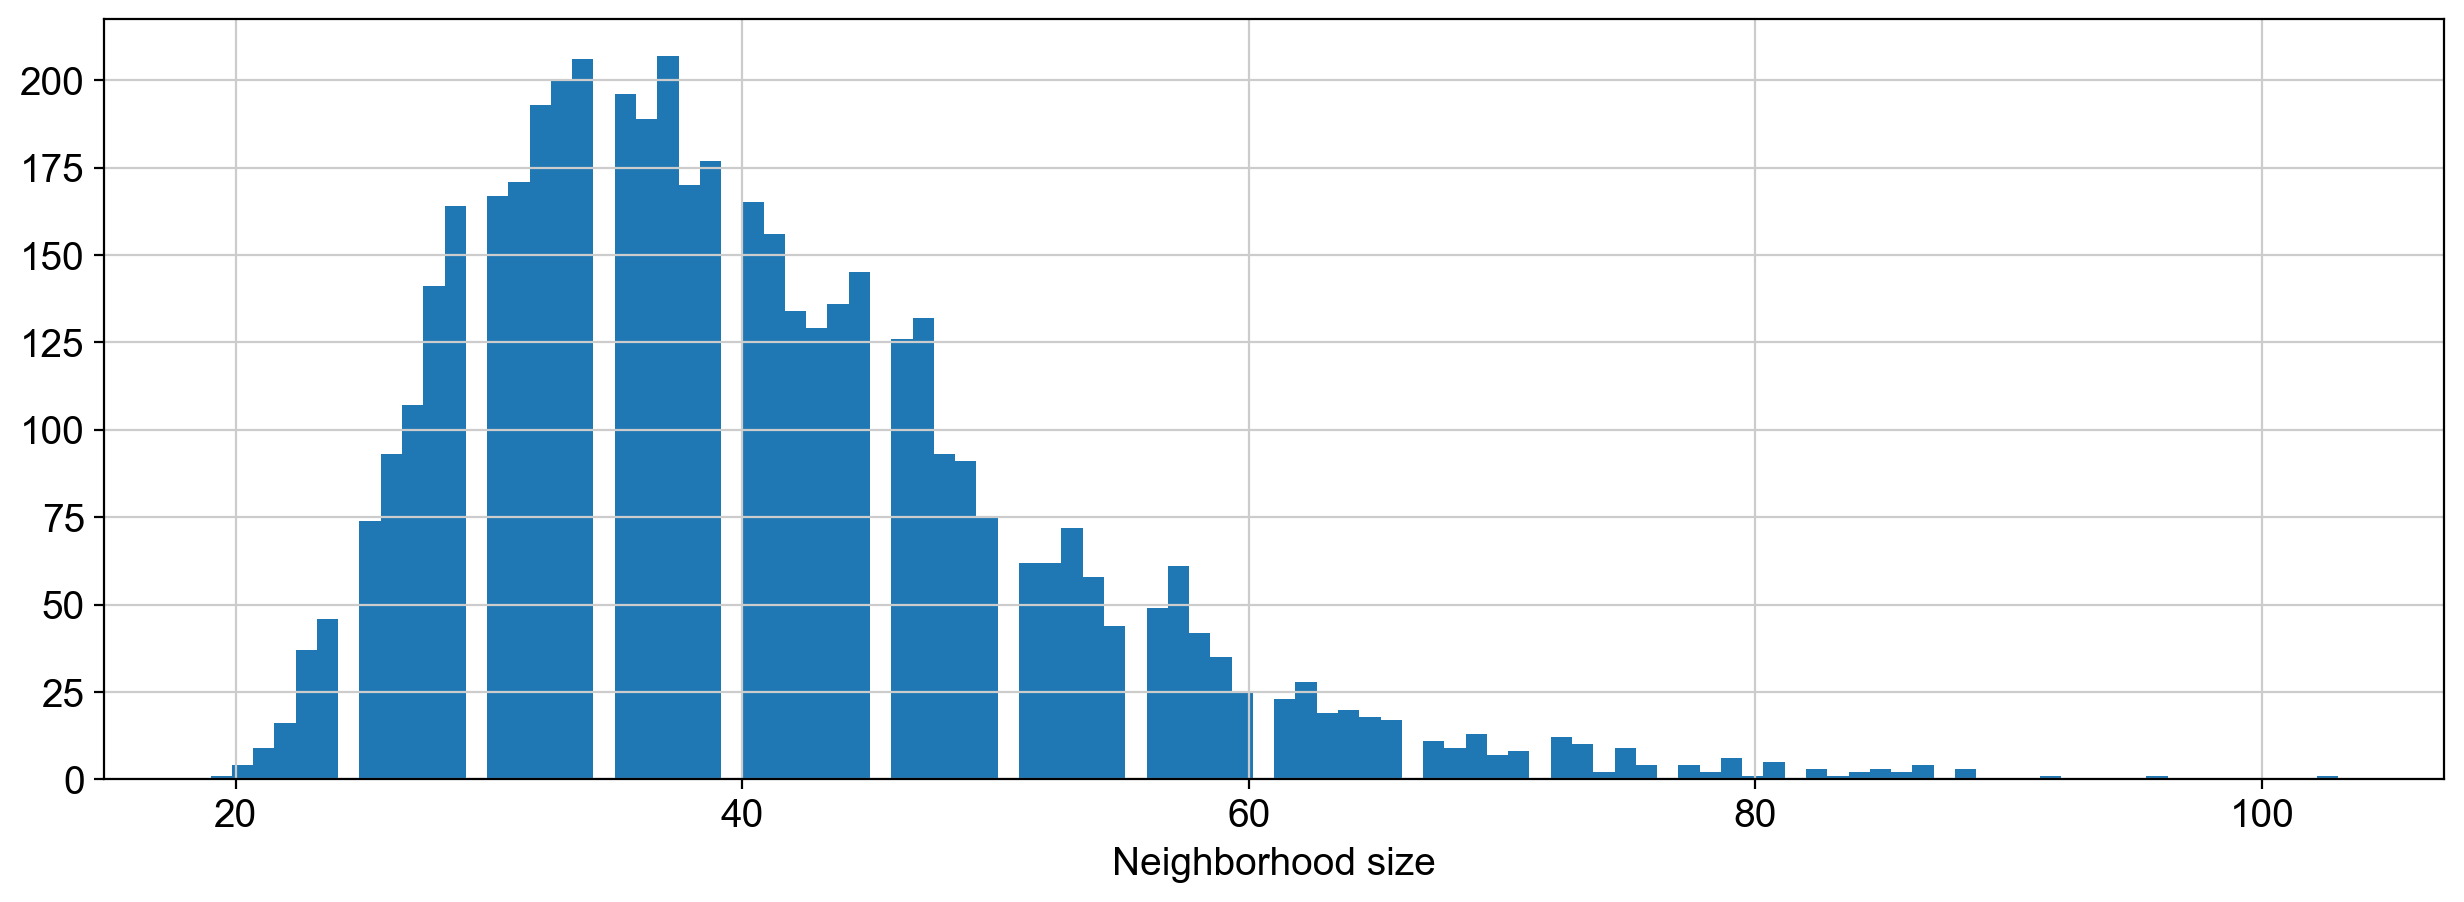

In [33]:
# Plot Neighborhood size distribution
sc.set_figure_params(figsize=(15, 5),dpi=100)
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)
plt.xlabel("Neighborhood size")
plt.show()

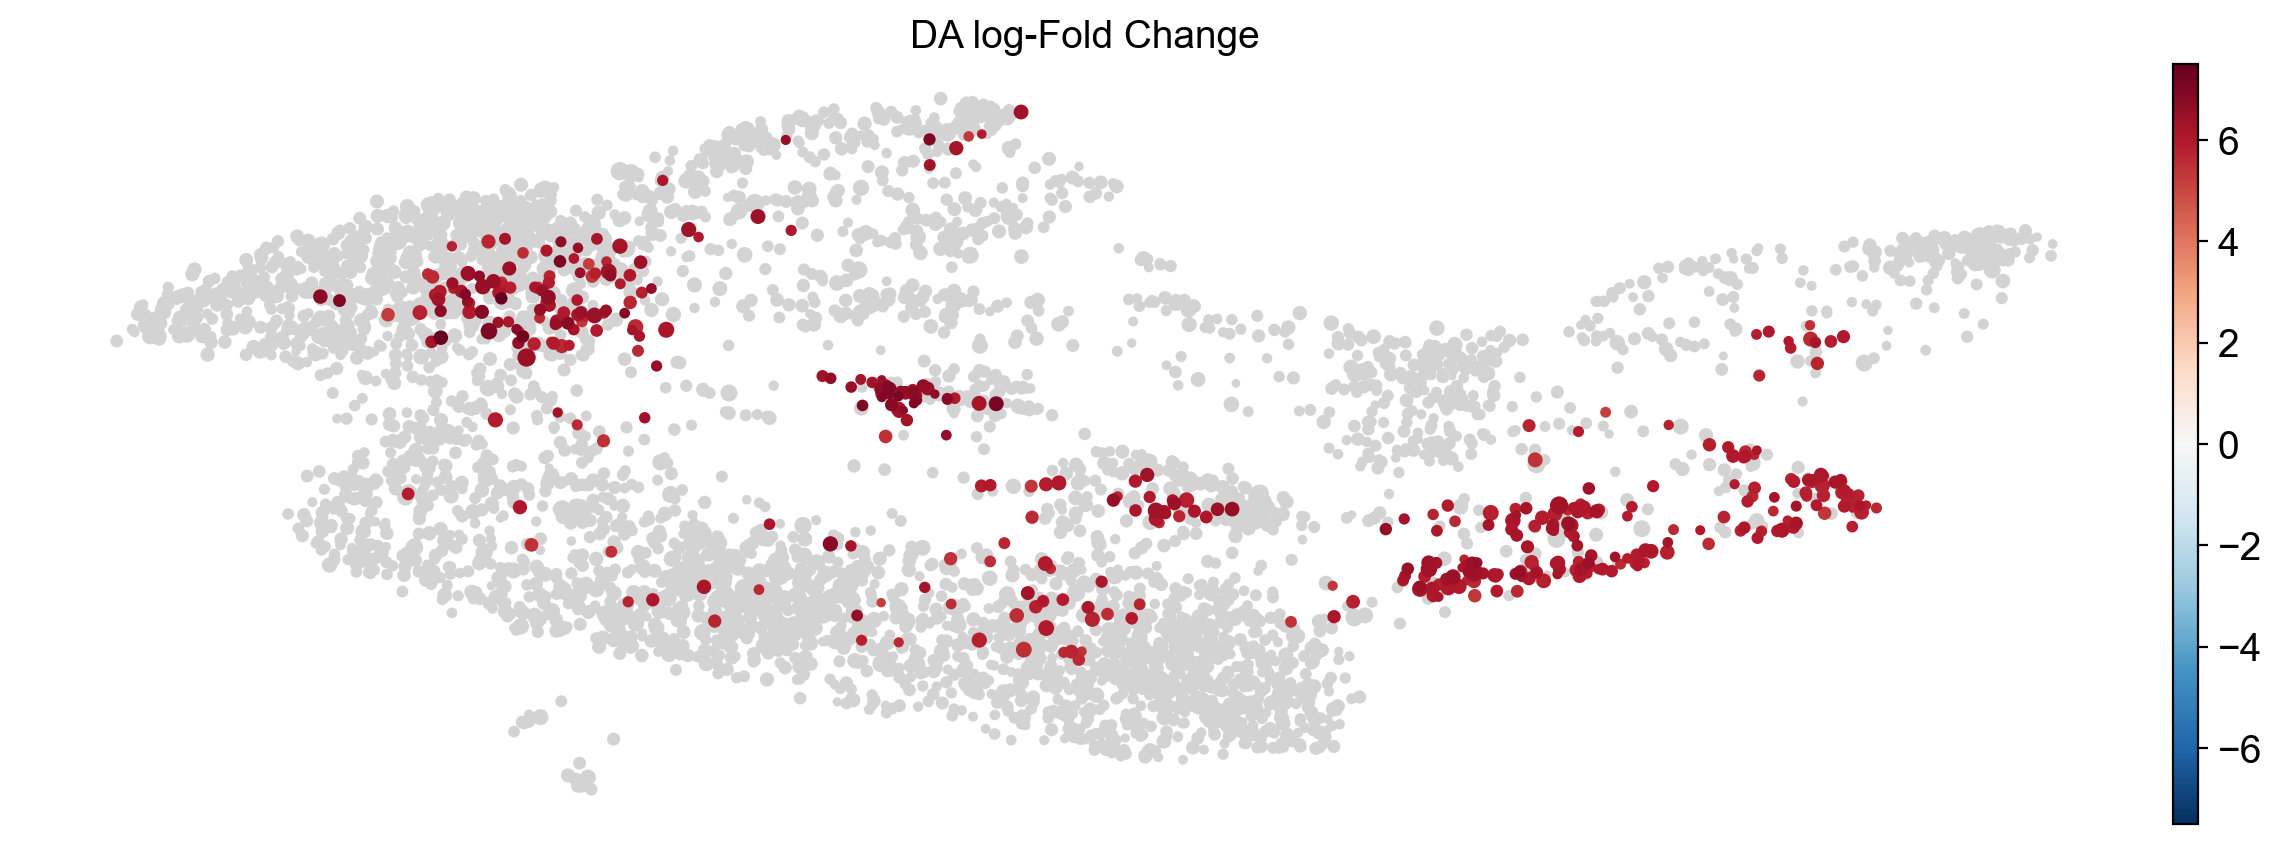

In [34]:
# Plot embedding with neighborhood graph

milopy.utils.build_nhood_graph(adata)

alpha=0.1
min_size=2
min_logFC: float = 0
plot_edges: bool = False
title: str = "DA log-Fold Change"

nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan

# Plotting order - extreme logFC on top
nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(),
                        "abs_logFC"] = np.nan
ordered = nhood_adata.obs.sort_values(
        'abs_logFC', na_position='first').index
nhood_adata = nhood_adata[ordered]

vmax = np.max([nhood_adata.obs["graph_color"].max(),
                  abs(nhood_adata.obs["graph_color"].min())])
vmin = - vmax

sc.pl.embedding(nhood_adata, "X_milo_graph", color="graph_color", cmap="RdBu_r", title=title, vmax=vmax, vmin=vmin,frameon=False, sort_order=False, 
edges=plot_edges, neighbors_key="nhood", size=adata.uns["nhood_adata"].obs["Nhood_size"]*min_size)

In [35]:
nhood_adata.obs

index_cell  kth_distance     logFC    logCPM         F  \
0     180867-ST07_CSE_CTRL-V1   1761.346191 -3.890512  8.209276  4.399684   
1     518211-ST07_CSE_CTRL-V1    978.467590 -1.915484  8.180935  1.323137   
2     535058-ST07_CSE_CTRL-V1    480.342651 -1.283992  8.092492  0.633796   
3     104170-ST07_CSE_CTRL-V1    503.982208 -1.521059  8.769097  0.664416   
4     367551-ST07_CSE_CTRL-V1    707.739197 -2.003637  8.395377  1.399248   
...                       ...           ...       ...       ...       ...   
3421     8556290-CHE01_IAV-V3    184.456863  7.117452  9.143751  9.669683   
3473     1037983-CHE01_IAV-V3    165.775345  7.125457  9.150135  9.662388   
3233    14025221-CHE01_IAV-V3    349.600677  7.285764  9.280049  9.507937   
3217     2658482-CHE01_IAV-V3    400.459503  7.470920  9.433825  9.306742   
3298    13141659-CHE01_IAV-V3    277.568939  7.496802  9.456082  9.274315   

        PValue       FDR  SpatialFDR  Nhood_size  graph_color  abs_logFC  
0     0.035951  0.226754    0.504156        26.0          NaN        NaN  
1     0.250036  0.676601    0.997961        26.0          NaN        NaN  
2     0.425971  0.800796    0.997961        25.0          NaN        NaN  
3     0.415010  0.791848    0.997961        46.0          NaN        NaN  
4     0.236856  0.665426    0.997961        33.0          NaN        NaN  
...        ...       ...         ...         ...          ...        ...  
3421  0.001875  0.022462    0.056552        53.0     7.117452   7.117452  
3473  0.001882  0.022494    0.056552        53.0     7.125457   7.125457  
3233  0.002047  0.024221    0.060797        57.0     7.285764   7.285764  
3217  0.002285  0.026563    0.066792        63.0     7.470920   7.470920  
3298  0.002325  0.026904    0.067668        66.0     7.496802   7.496802  

[4709 rows x 11 columns]

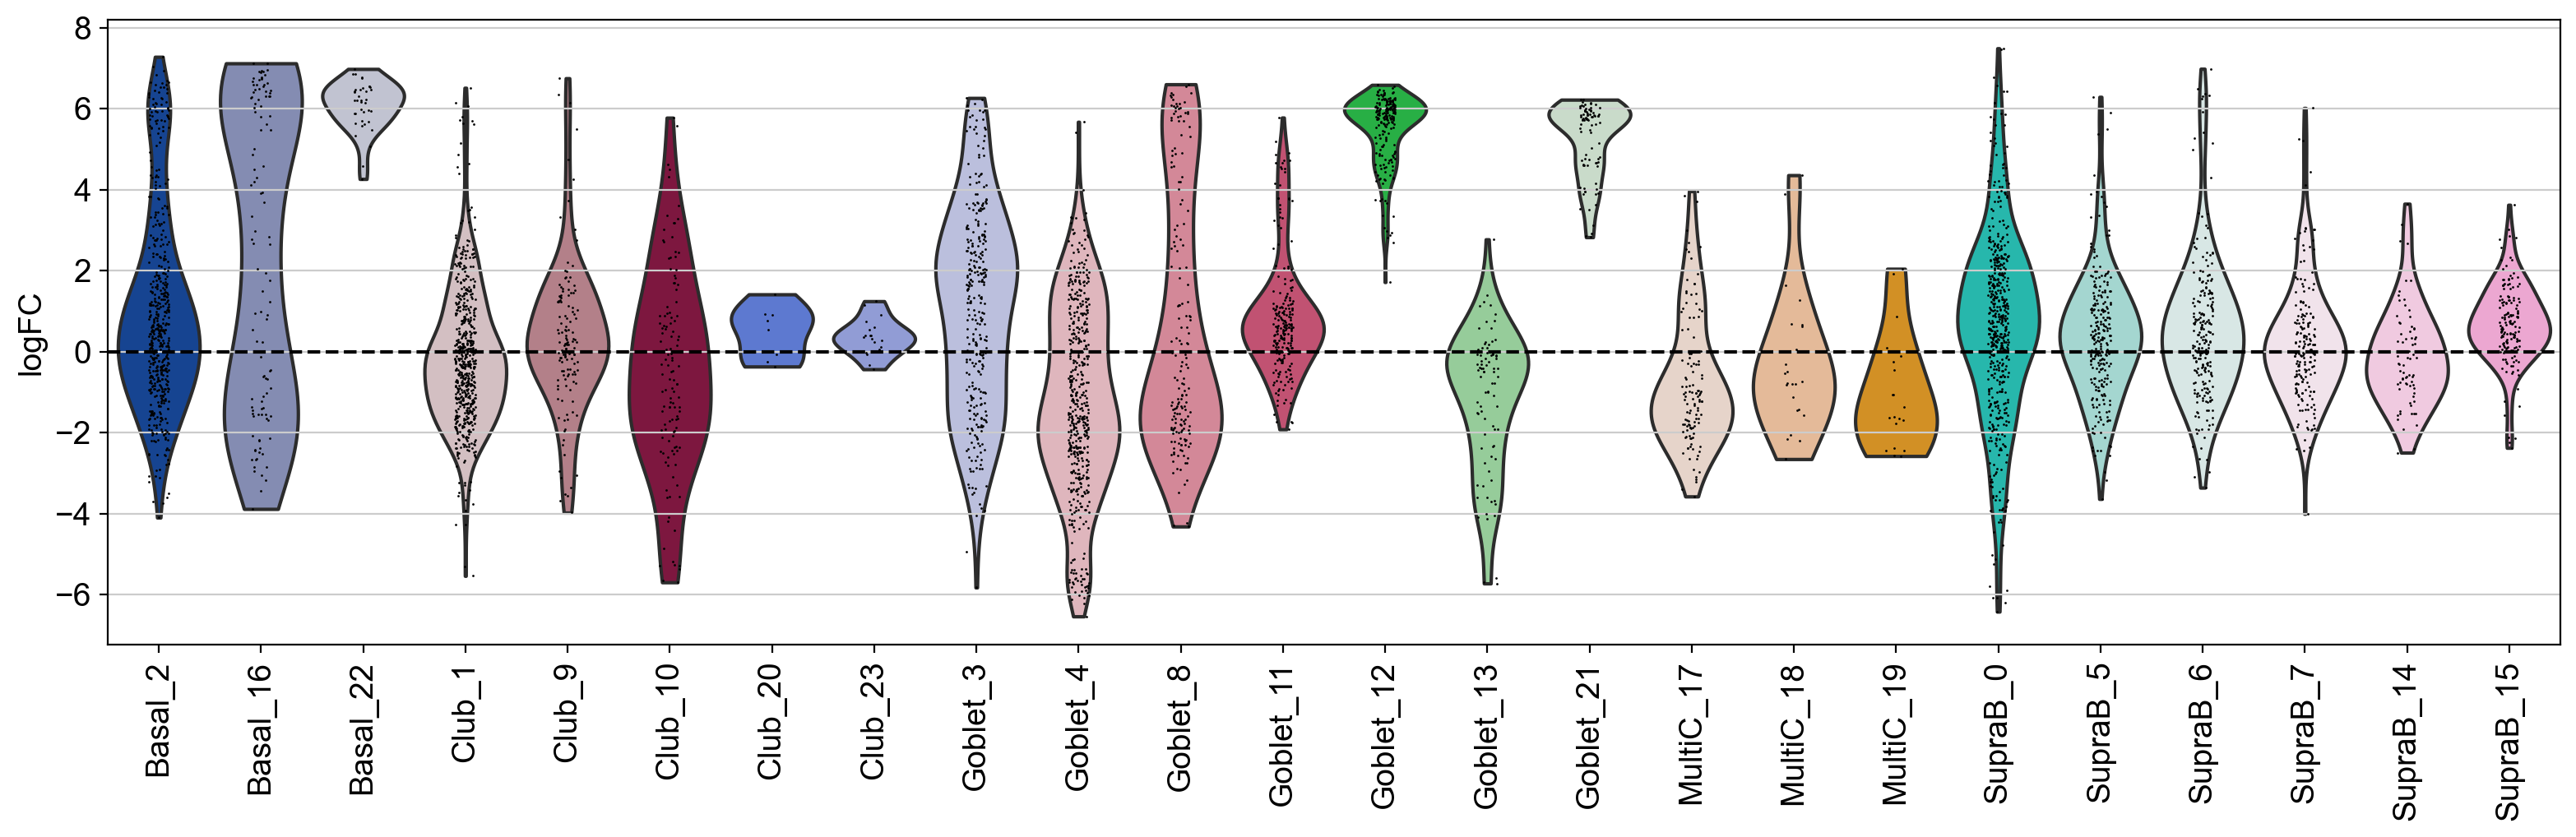

In [36]:
# Plot violin plots for differential abundance results by cell type
sc.set_figure_params(figsize=(15, 5),dpi=100)
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## Parameters change 2

In [37]:
adata = adata_raw.copy()

In [38]:
# Filter only healthy_ctrl and COPD_iav cells as they supposed to have the bigger variability
adata = adata[adata.obs['group'].isin(['healthy_ctrl', 'copd_iav'])]

In [39]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:22)


In [40]:
#Changing the number of neighbors and PCA dimensions to tutorial values and changing the prop value to 0.5

# Adjust the number of neighbors and PCA dimensions
k = 20
d = 40

# Re-run the analysis with the new parameters
sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)
milo.make_nhoods(adata, prop=0.5)
milo.count_nhoods(adata, sample_col="sample")
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes
milo.DA_nhoods(adata, design="~stage_continuous")

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [41]:
adata.uns["nhood_adata"].obs

index_cell  kth_distance     logFC    logCPM         F  \
0      653582-ST07_CSE_CTRL-V1    722.357666  0.609099  6.887903  0.129121   
1      180867-ST07_CSE_CTRL-V1   1761.346191 -3.796299  6.656942  4.303990   
2      797553-ST07_CSE_CTRL-V1    725.494141 -5.348228  6.578057  8.355491   
3      518211-ST07_CSE_CTRL-V1    978.467590 -1.981580  6.616903  1.456199   
4      192197-ST07_CSE_CTRL-V1    516.285156 -1.548538  6.782004  0.837667   
...                        ...           ...       ...       ...       ...   
14531     4720207-CSE03_IAV-V6    118.313622 -0.223839  6.720329  0.020119   
14532    12536461-CSE03_IAV-V6     93.276131  1.358817  6.935388  0.640895   
14533     8274833-CSE03_IAV-V6    112.189857  0.673851  6.799713  0.172431   
14534     9598877-CSE03_IAV-V6     92.731514 -0.167434  6.937508  0.009650   
14535     7817184-CSE03_IAV-V6    234.313965  0.211797  6.482725  0.019498   

         PValue       FDR  SpatialFDR  
0      0.719345  0.927397    0.999349  
1      0.038025  0.227649    0.522647  
2      0.003846  0.041844    0.106177  
3      0.227538  0.624644    0.999349  
4      0.360067  0.740236    0.999349  
...         ...       ...         ...  
14531  0.887205  0.976409    0.999349  
14532  0.423388  0.782601    0.999349  
14533  0.677961  0.911770    0.999349  
14534  0.921746  0.984743    0.999349  
14535  0.888948  0.977035    0.999349  

[14536 rows x 8 columns]

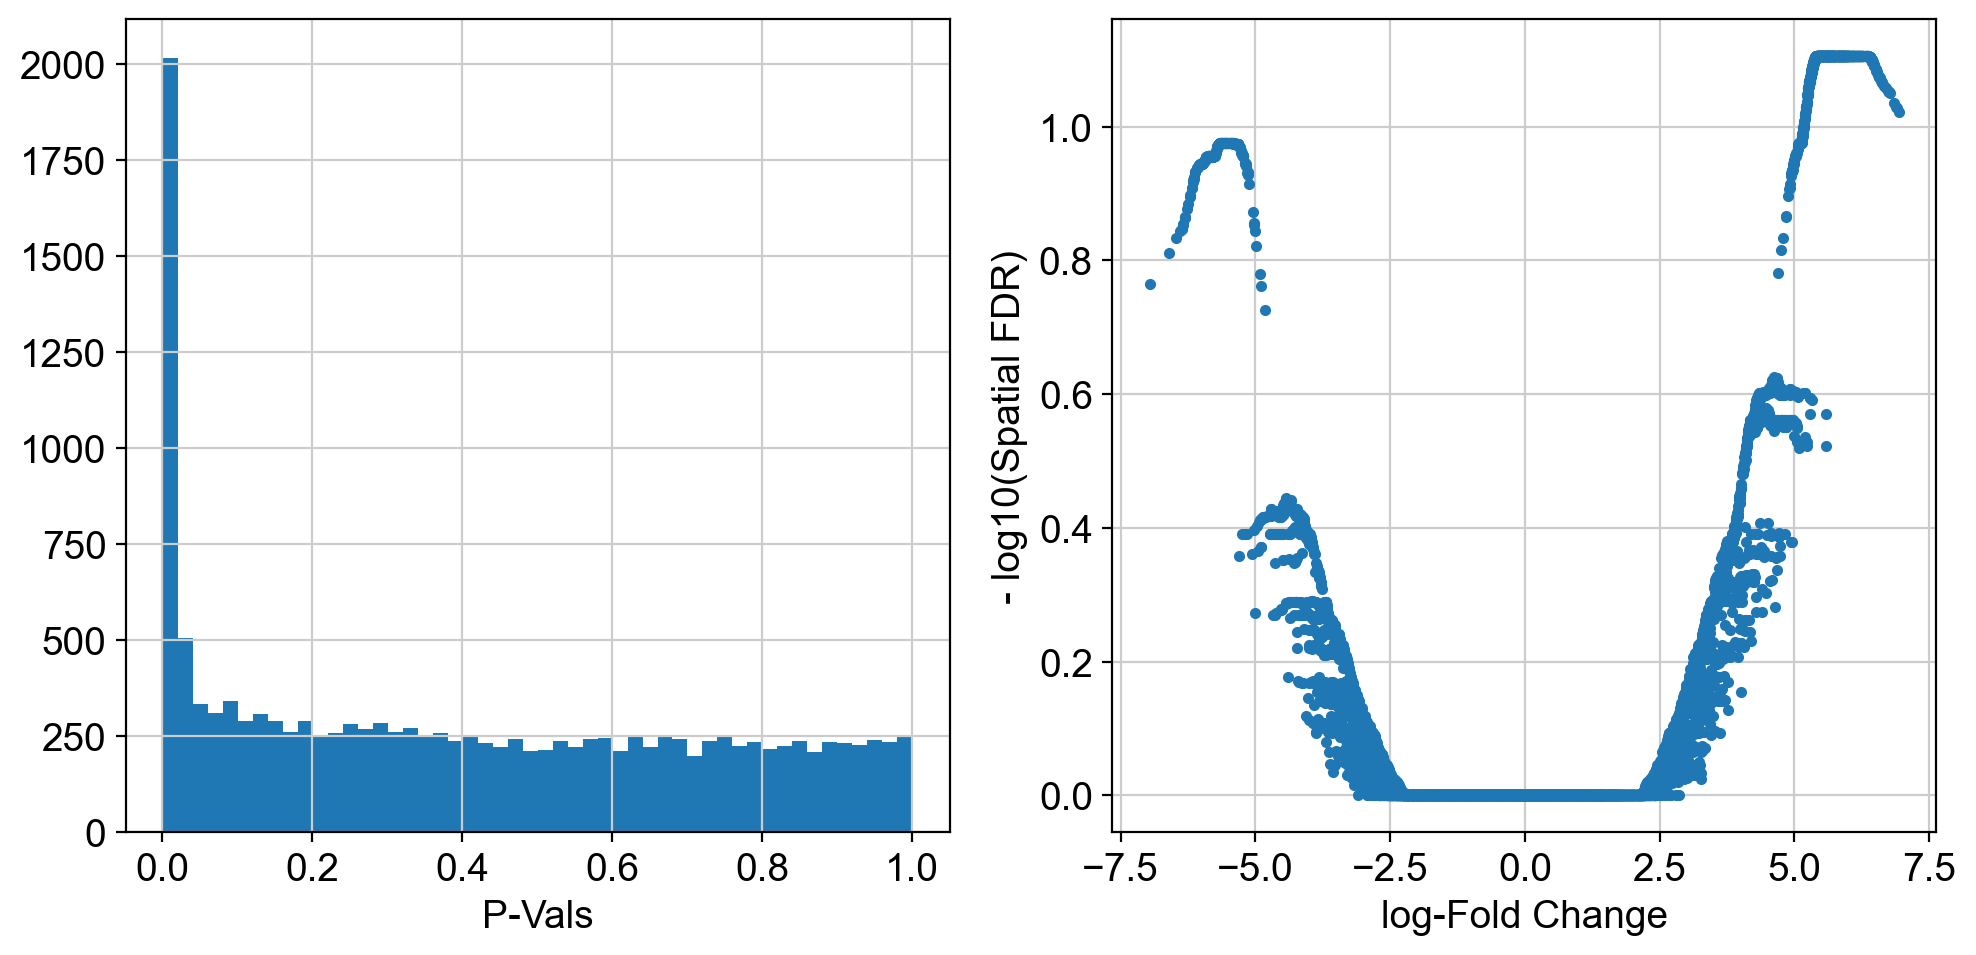

In [42]:
# Plot p-value histogram and Volcano plot with log-Fold Change (x-axis) against -log10(Spatial FDR) (y-axis). 
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [43]:
# Calculate how much cells pass the threshold FDR < 0.05 & p-value < 0.05 & logFC > 0.5
adata.uns["nhood_adata"].obs[(adata.uns["nhood_adata"].obs.SpatialFDR < 0.1) & (adata.uns["nhood_adata"].obs.PValue < 0.05) & (adata.uns["nhood_adata"].obs.logFC > 0.5)].shape[0]

1200

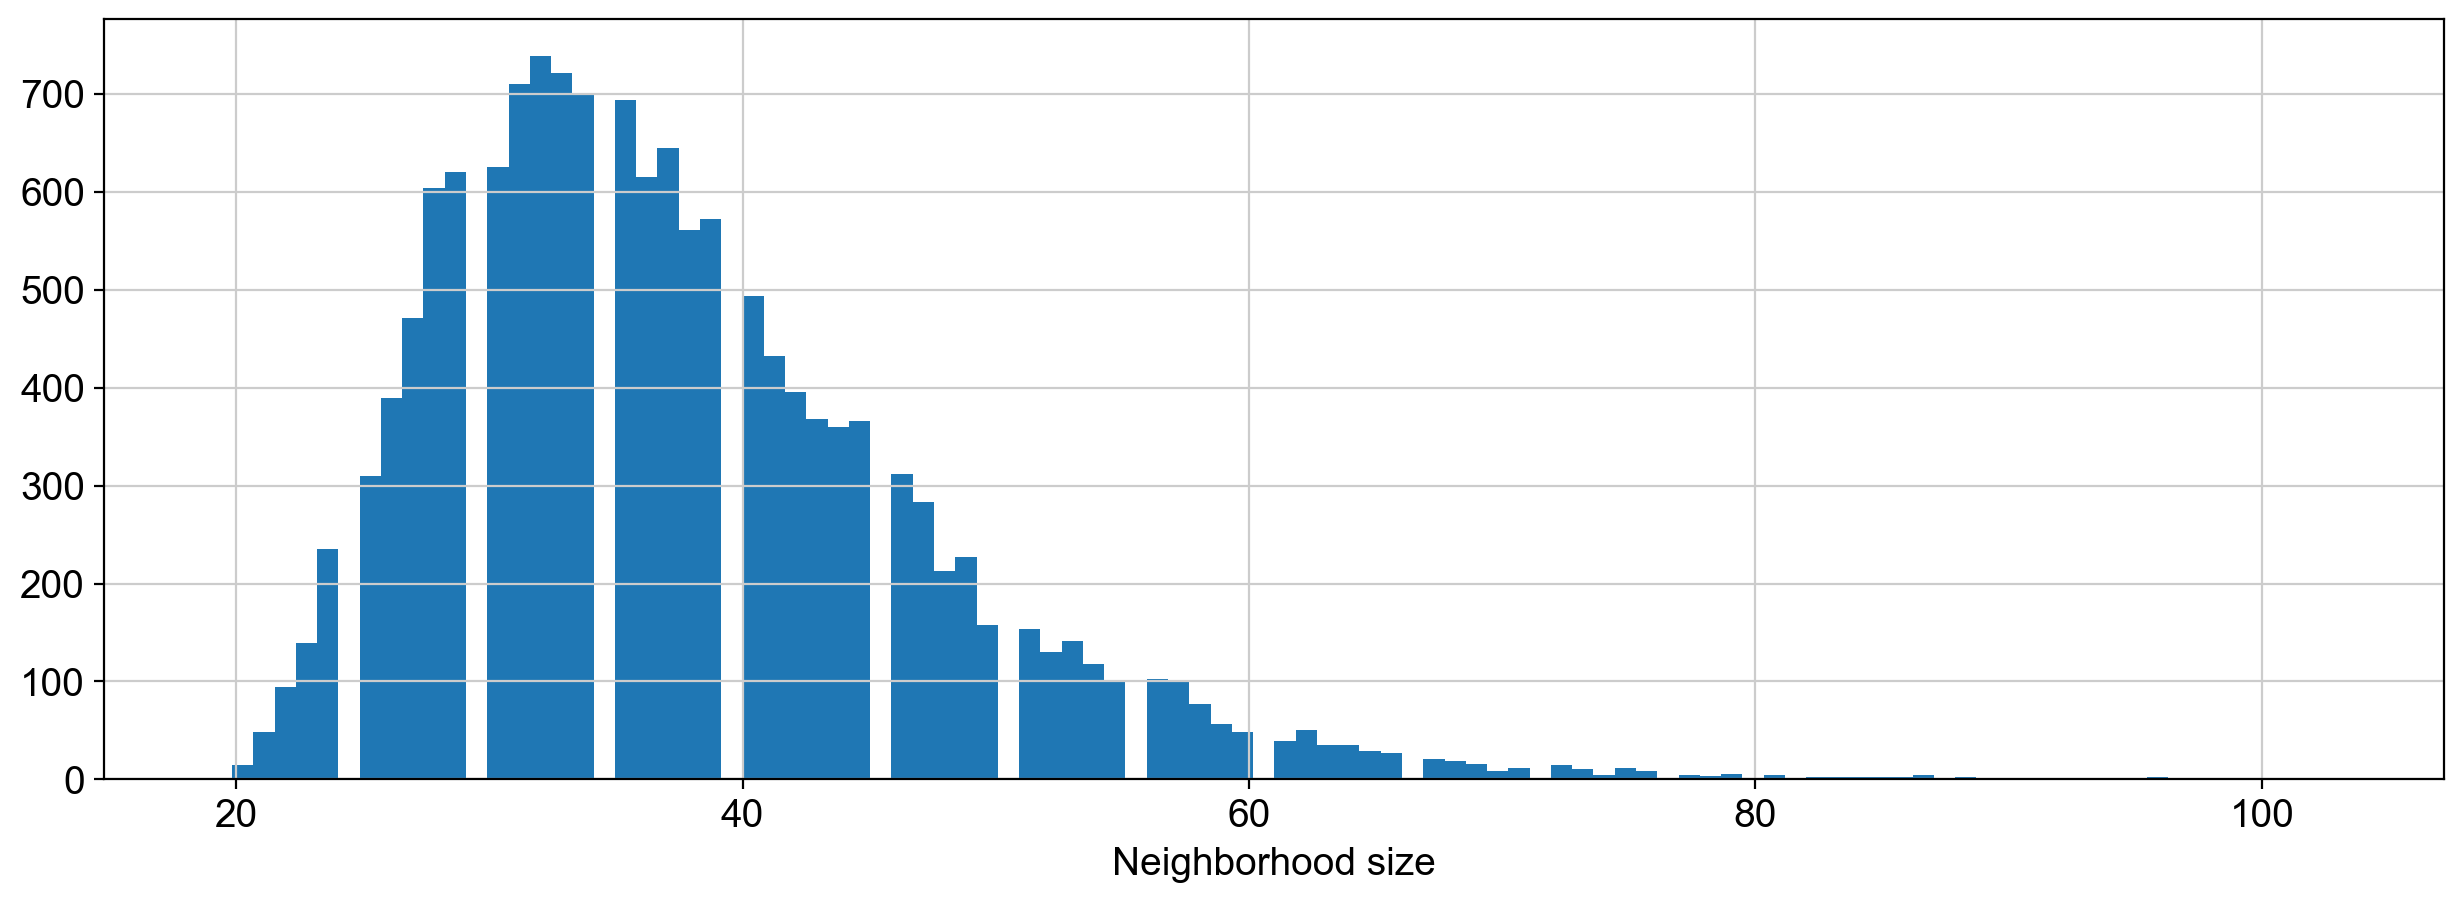

In [44]:
# Plot Neighborhood size distribution
sc.set_figure_params(figsize=(15, 5),dpi=100)
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)
plt.xlabel("Neighborhood size")
plt.show()

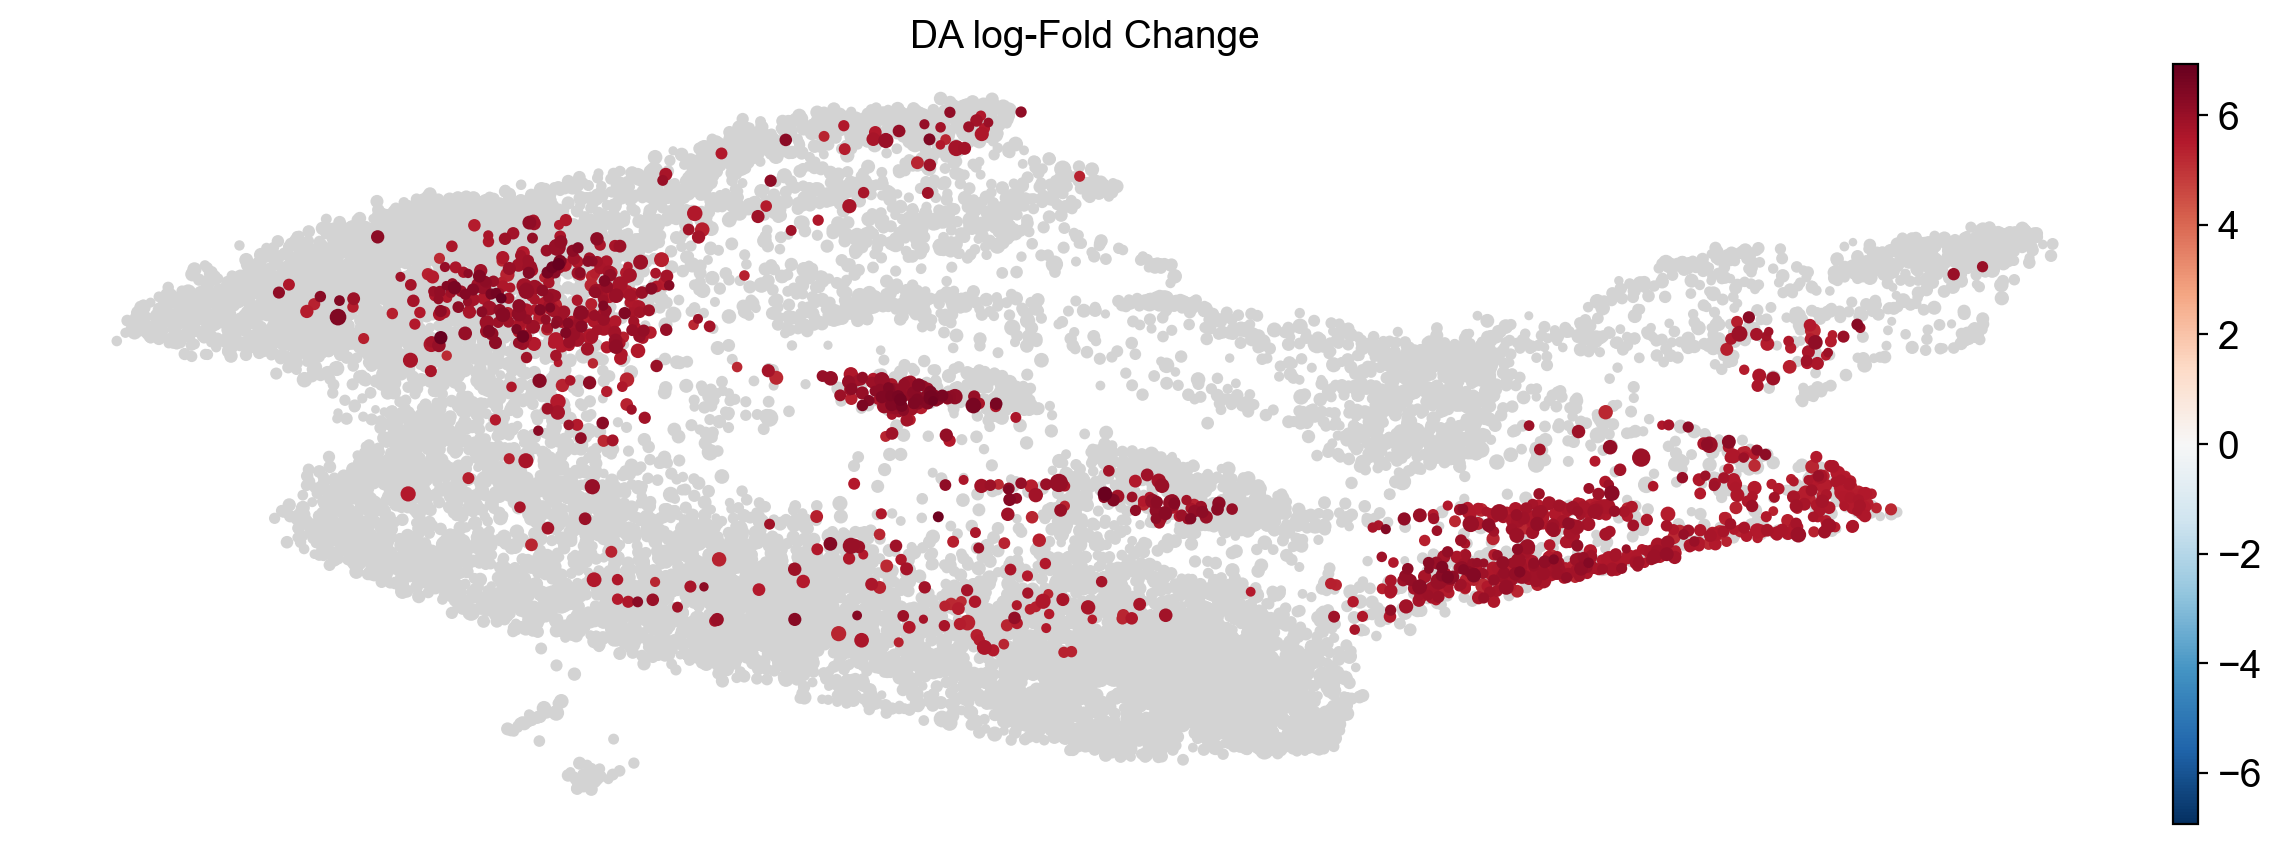

In [49]:
# Plot embedding with neighborhood graph

milopy.utils.build_nhood_graph(adata)

alpha=0.1
min_size=2
min_logFC: float = 0
plot_edges: bool = False
title: str = "DA log-Fold Change"

nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan

# Plotting order - extreme logFC on top
nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(),
                        "abs_logFC"] = np.nan
ordered = nhood_adata.obs.sort_values(
        'abs_logFC', na_position='first').index
nhood_adata = nhood_adata[ordered]

vmax = np.max([nhood_adata.obs["graph_color"].max(),
                  abs(nhood_adata.obs["graph_color"].min())])
vmin = - vmax

sc.pl.embedding(nhood_adata, "X_milo_graph", color="graph_color", cmap="RdBu_r", title=title, vmax=vmax, vmin=vmin,frameon=False, sort_order=False, 
edges=plot_edges, neighbors_key="nhood", size=adata.uns["nhood_adata"].obs["Nhood_size"]*min_size)

In [46]:
nhood_adata.obs

index_cell  kth_distance     logFC    logCPM         F  \
0      653582-ST07_CSE_CTRL-V1    722.357666  0.609099  6.887903  0.129121   
3      518211-ST07_CSE_CTRL-V1    978.467590 -1.981580  6.616903  1.456199   
4      192197-ST07_CSE_CTRL-V1    516.285156 -1.548538  6.782004  0.837667   
5      619760-ST07_CSE_CTRL-V1    427.691956 -1.523416  6.811435  0.790103   
6      535058-ST07_CSE_CTRL-V1    480.342651 -1.446955  6.543871  0.831715   
...                        ...           ...       ...       ...       ...   
14273     9595419-CSE03_IAV-V6    215.979996  6.854429  7.433596  8.828082   
10113     5189827-CHE01_IAV-V3    440.304382  6.888410  7.458994  8.797918   
10062     2658482-CHE01_IAV-V3    400.459503  6.897931  7.466299  8.788955   
10319    13141659-CHE01_IAV-V3    277.568939  6.933678  7.494461  8.755046   
725    731689-ST07_CSE_CTRL-V1    178.309067 -6.958707  7.720633  7.230638   

         PValue       FDR  SpatialFDR  Nhood_size  graph_color  abs_logFC  
0      0.719345  0.927397    0.999349        30.0          NaN        NaN  
3      0.227538  0.624644    0.999349        26.0          NaN        NaN  
4      0.360067  0.740236    0.999349        30.0          NaN        NaN  
5      0.374071  0.749763    0.999349        31.0          NaN        NaN  
6      0.361779  0.741191    0.999349        25.0          NaN        NaN  
...         ...       ...         ...         ...          ...        ...  
14273  0.002967  0.036673    0.092230        71.0     6.854429   6.854429  
10113  0.003016  0.037137    0.093558        63.0     6.888410   6.888410  
10062  0.003031  0.037213    0.093702        63.0     6.897931   6.897931  
10319  0.003088  0.037784    0.095171        66.0     6.933678   6.933678  
725    0.007168  0.068189    0.172078        74.0    -6.958707   6.958707  

[14536 rows x 11 columns]

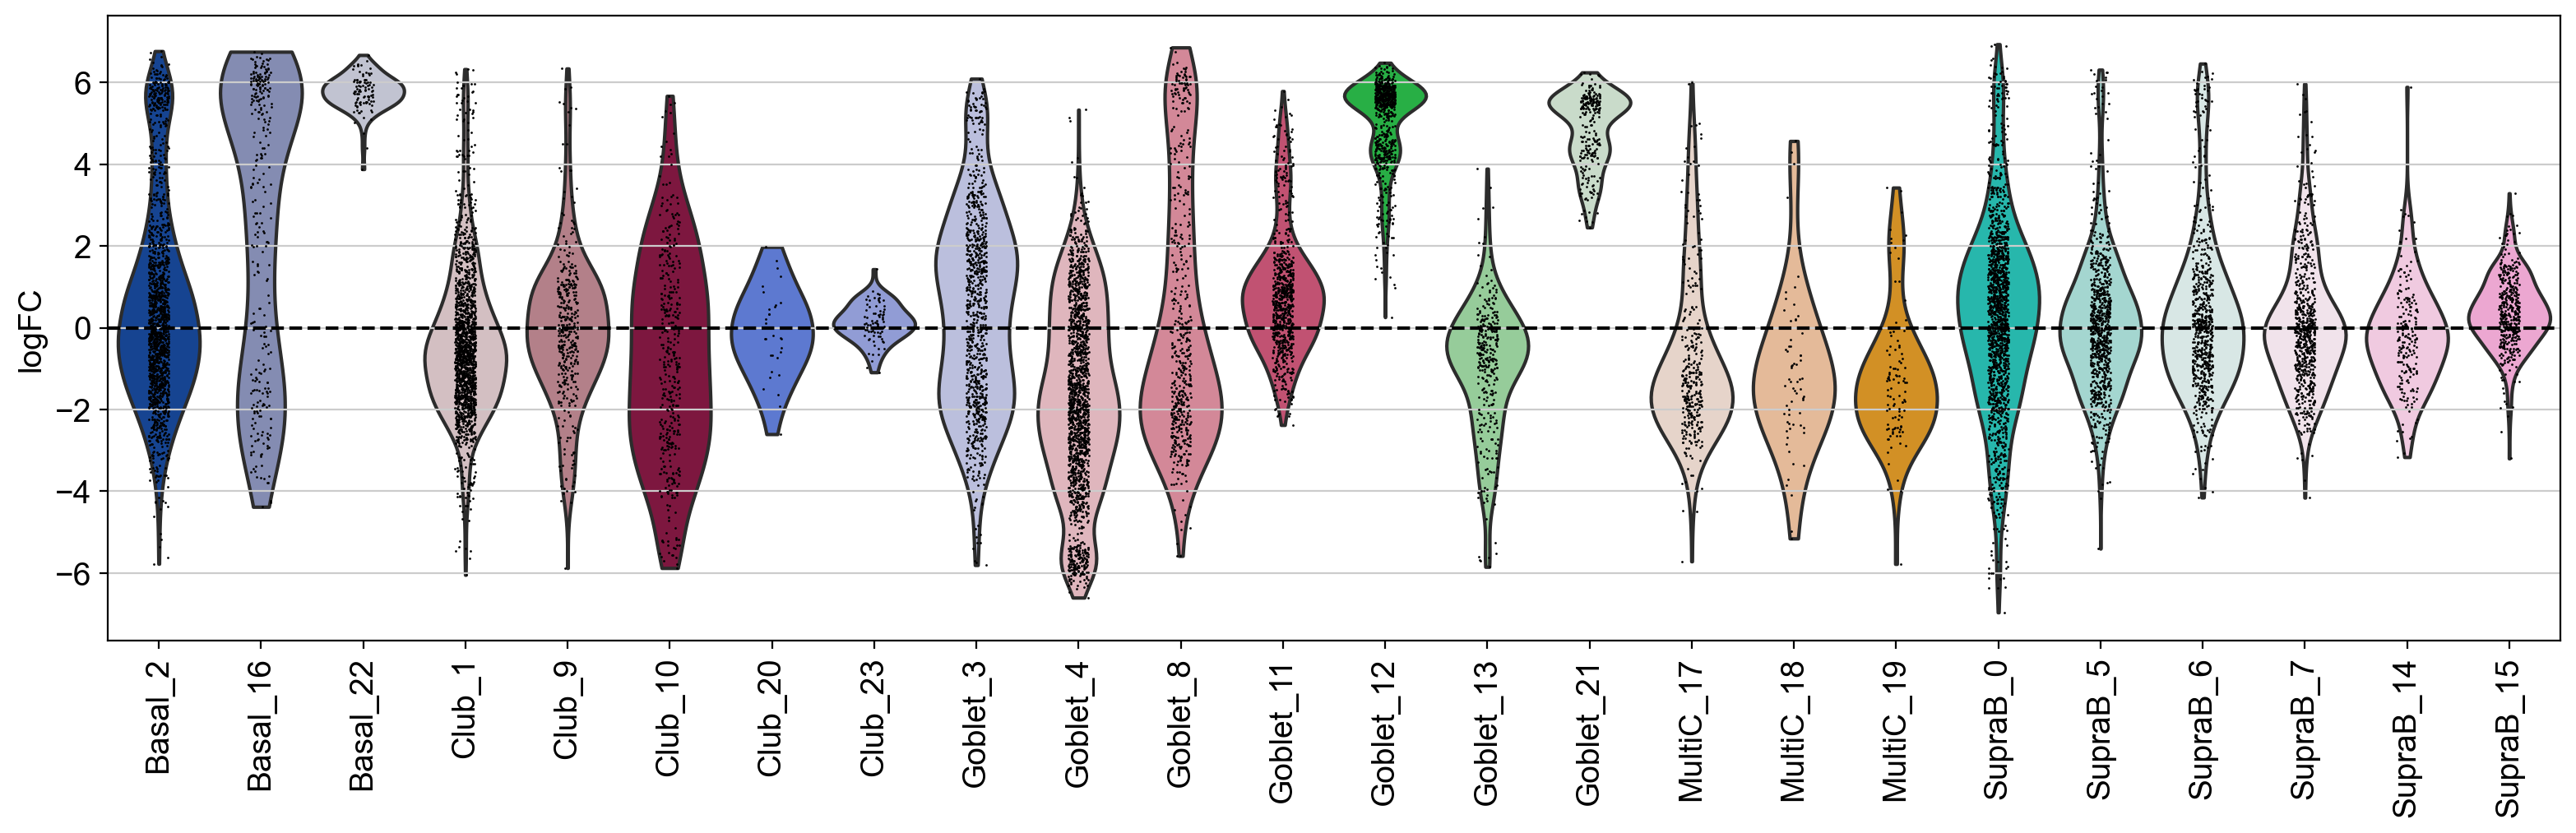

In [50]:
# Plot violin plots for differential abundance results by cell type
sc.set_figure_params(figsize=(15, 5),dpi=100)
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

## Parameters change 3

In [51]:
adata = adata_raw.copy()

In [52]:
# Filter only healthy_ctrl and COPD_iav cells as they supposed to have the bigger variability
adata = adata[adata.obs['group'].isin(['healthy_ctrl', 'copd_iav'])]

In [53]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)


In [54]:
#Changing the number of neighbors and PCA dimensions to tutorial values and changing the prop value to 0.5

# Adjust the number of neighbors and PCA dimensions
k = 10
d = 30

# Re-run the analysis with the new parameters
sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)
milo.make_nhoods(adata, prop=0.5)
milo.count_nhoods(adata, sample_col="sample")
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes
milo.DA_nhoods(adata, design="~stage_continuous")

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)


/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [55]:
adata.uns["nhood_adata"].obs

index_cell  kth_distance     logFC    logCPM         F  \
0      653582-ST07_CSE_CTRL-V1    604.491211  0.654750  7.317104  0.151579   
1      501732-ST07_CSE_CTRL-V1   1420.670410 -4.299079  7.079493  6.239715   
2      180867-ST07_CSE_CTRL-V1   1433.512939 -3.103506  7.210636  2.958974   
3      831290-ST07_CSE_CTRL-V1    468.708344 -0.637534  7.011492  0.165499   
4      715242-ST07_CSE_CTRL-V1    716.876587 -0.160972  7.116250  0.009955   
...                        ...           ...       ...       ...       ...   
16193      151392-CSE03_IAV-V6     93.080444  0.241718  7.180457  0.022580   
16194    12536461-CSE03_IAV-V6     70.985489  1.291953  7.180668  0.644387   
16195     8274833-CSE03_IAV-V6     90.288963  1.186902  6.983860  0.605847   
16196     9598877-CSE03_IAV-V6     70.051247  0.058878  7.475171  0.001126   
16197     7817184-CSE03_IAV-V6    199.221863  0.818000  7.079908  0.272643   

         PValue       FDR  SpatialFDR  
0      0.697031  0.895916    0.998649  
1      0.012493  0.074561    0.162374  
2      0.085404  0.338343    0.651927  
3      0.684144  0.888888    0.998649  
4      0.920525  0.980093    0.998649  
...         ...       ...         ...  
16193  0.880554  0.966706    0.998649  
16194  0.422128  0.744891    0.996729  
16195  0.436357  0.754642    0.998649  
16196  0.973228  0.992754    0.998649  
16197  0.601565  0.847717    0.998649  

[16198 rows x 8 columns]

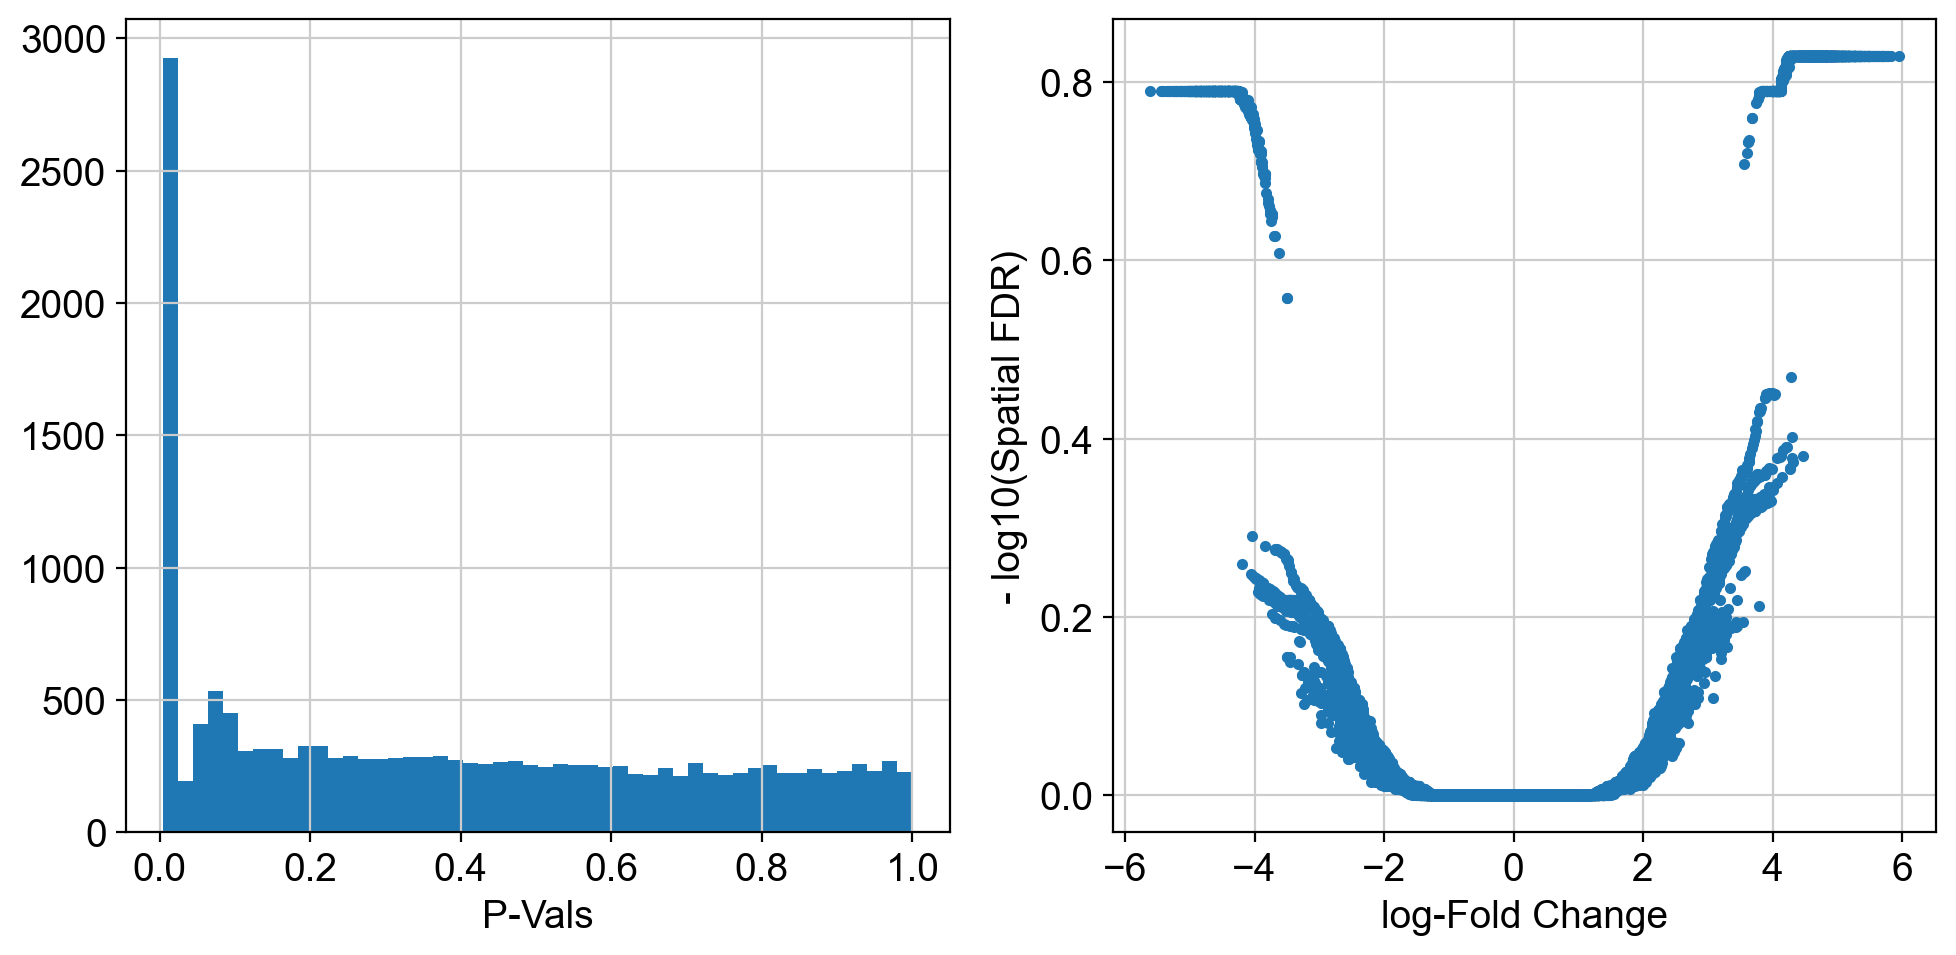

In [56]:
# Plot p-value histogram and Volcano plot with log-Fold Change (x-axis) against -log10(Spatial FDR) (y-axis). 
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

In [57]:
# Calculate how much cells pass the threshold FDR < 0.05 & p-value < 0.05 & logFC > 0.5
adata.uns["nhood_adata"].obs[(adata.uns["nhood_adata"].obs.SpatialFDR < 0.1) & (adata.uns["nhood_adata"].obs.PValue < 0.05) & (adata.uns["nhood_adata"].obs.logFC > 0.5)].shape[0]

0

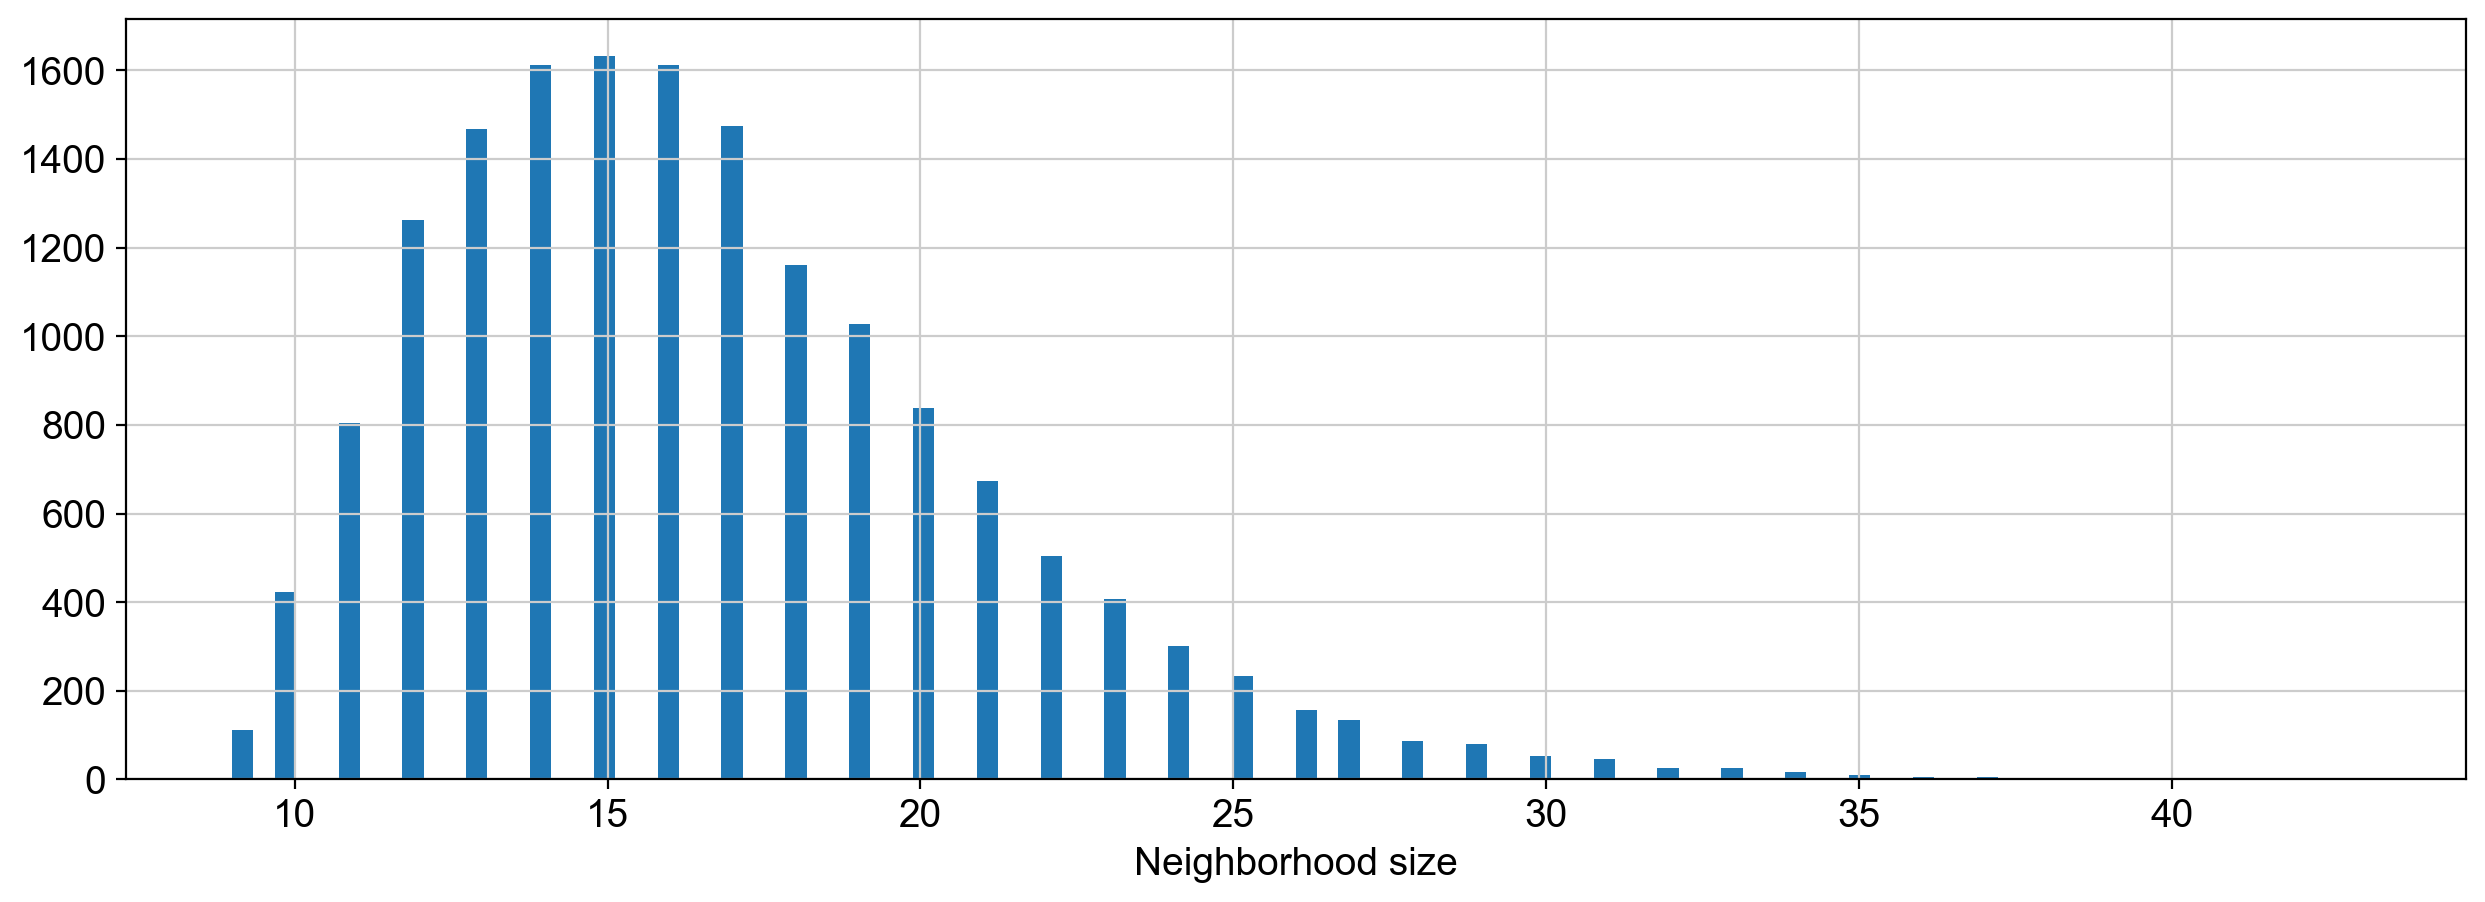

In [58]:
# Plot Neighborhood size distribution
sc.set_figure_params(figsize=(15, 5),dpi=100)
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100)
plt.xlabel("Neighborhood size")
plt.show()

StopIteration: 

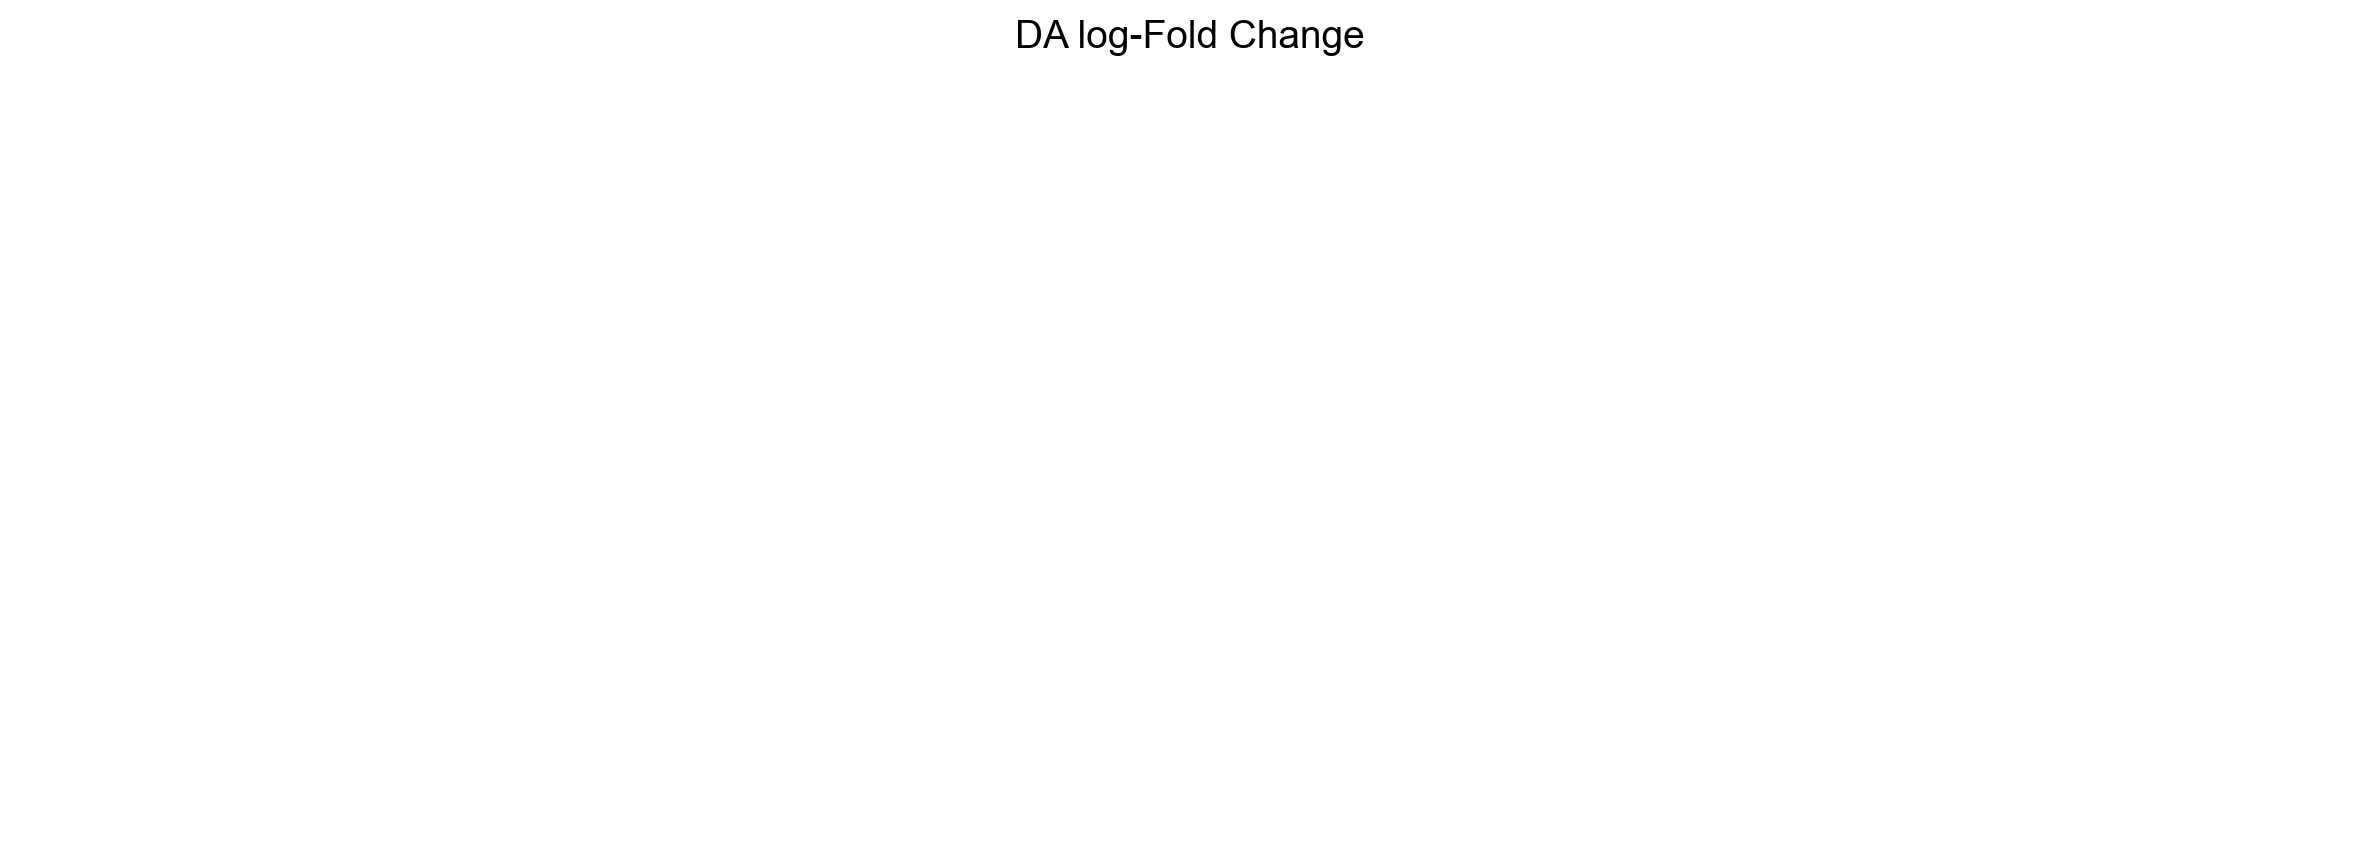

In [59]:
# Plot embedding with neighborhood graph

milopy.utils.build_nhood_graph(adata)

alpha=0.1
min_size=2
min_logFC: float = 0
plot_edges: bool = False
title: str = "DA log-Fold Change"

nhood_adata = adata.uns["nhood_adata"].copy()
nhood_adata.obs["graph_color"] = nhood_adata.obs["logFC"]
nhood_adata.obs.loc[nhood_adata.obs["SpatialFDR"] > alpha, "graph_color"] = np.nan
nhood_adata.obs["abs_logFC"] = abs(nhood_adata.obs["logFC"])
nhood_adata.obs.loc[nhood_adata.obs["abs_logFC"] < min_logFC, "graph_color"] = np.nan

# Plotting order - extreme logFC on top
nhood_adata.obs.loc[nhood_adata.obs["graph_color"].isna(),
                        "abs_logFC"] = np.nan
ordered = nhood_adata.obs.sort_values(
        'abs_logFC', na_position='first').index
nhood_adata = nhood_adata[ordered]

vmax = np.max([nhood_adata.obs["graph_color"].max(),
                  abs(nhood_adata.obs["graph_color"].min())])
vmin = - vmax

sc.pl.embedding(nhood_adata, "X_milo_graph", color="graph_color", cmap="RdBu_r", title=title, vmax=vmax, vmin=vmin,frameon=False, sort_order=False, 
edges=plot_edges, neighbors_key="nhood", size=adata.uns["nhood_adata"].obs["Nhood_size"]*min_size)

In [ ]:
nhood_adata.obs

index_cell  kth_distance     logFC    logCPM         F  \
0      653582-ST07_CSE_CTRL-V1    722.357666  0.609099  6.887903  0.129121   
3      518211-ST07_CSE_CTRL-V1    978.467590 -1.981580  6.616903  1.456199   
4      192197-ST07_CSE_CTRL-V1    516.285156 -1.548538  6.782004  0.837667   
5      619760-ST07_CSE_CTRL-V1    427.691956 -1.523416  6.811435  0.790103   
6      535058-ST07_CSE_CTRL-V1    480.342651 -1.446955  6.543871  0.831715   
...                        ...           ...       ...       ...       ...   
14273     9595419-CSE03_IAV-V6    215.979996  6.854429  7.433596  8.828082   
10113     5189827-CHE01_IAV-V3    440.304382  6.888410  7.458994  8.797918   
10062     2658482-CHE01_IAV-V3    400.459503  6.897931  7.466299  8.788955   
10319    13141659-CHE01_IAV-V3    277.568939  6.933678  7.494461  8.755046   
725    731689-ST07_CSE_CTRL-V1    178.309067 -6.958707  7.720633  7.230638   

         PValue       FDR  SpatialFDR  Nhood_size  graph_color  abs_logFC  
0      0.719345  0.927397    0.999349        30.0          NaN        NaN  
3      0.227538  0.624644    0.999349        26.0          NaN        NaN  
4      0.360067  0.740236    0.999349        30.0          NaN        NaN  
5      0.374071  0.749763    0.999349        31.0          NaN        NaN  
6      0.361779  0.741191    0.999349        25.0          NaN        NaN  
...         ...       ...         ...         ...          ...        ...  
14273  0.002967  0.036673    0.092230        71.0     6.854429   6.854429  
10113  0.003016  0.037137    0.093558        63.0     6.888410   6.888410  
10062  0.003031  0.037213    0.093702        63.0     6.897931   6.897931  
10319  0.003088  0.037784    0.095171        66.0     6.933678   6.933678  
725    0.007168  0.068189    0.172078        74.0    -6.958707   6.958707  

[14536 rows x 11 columns]

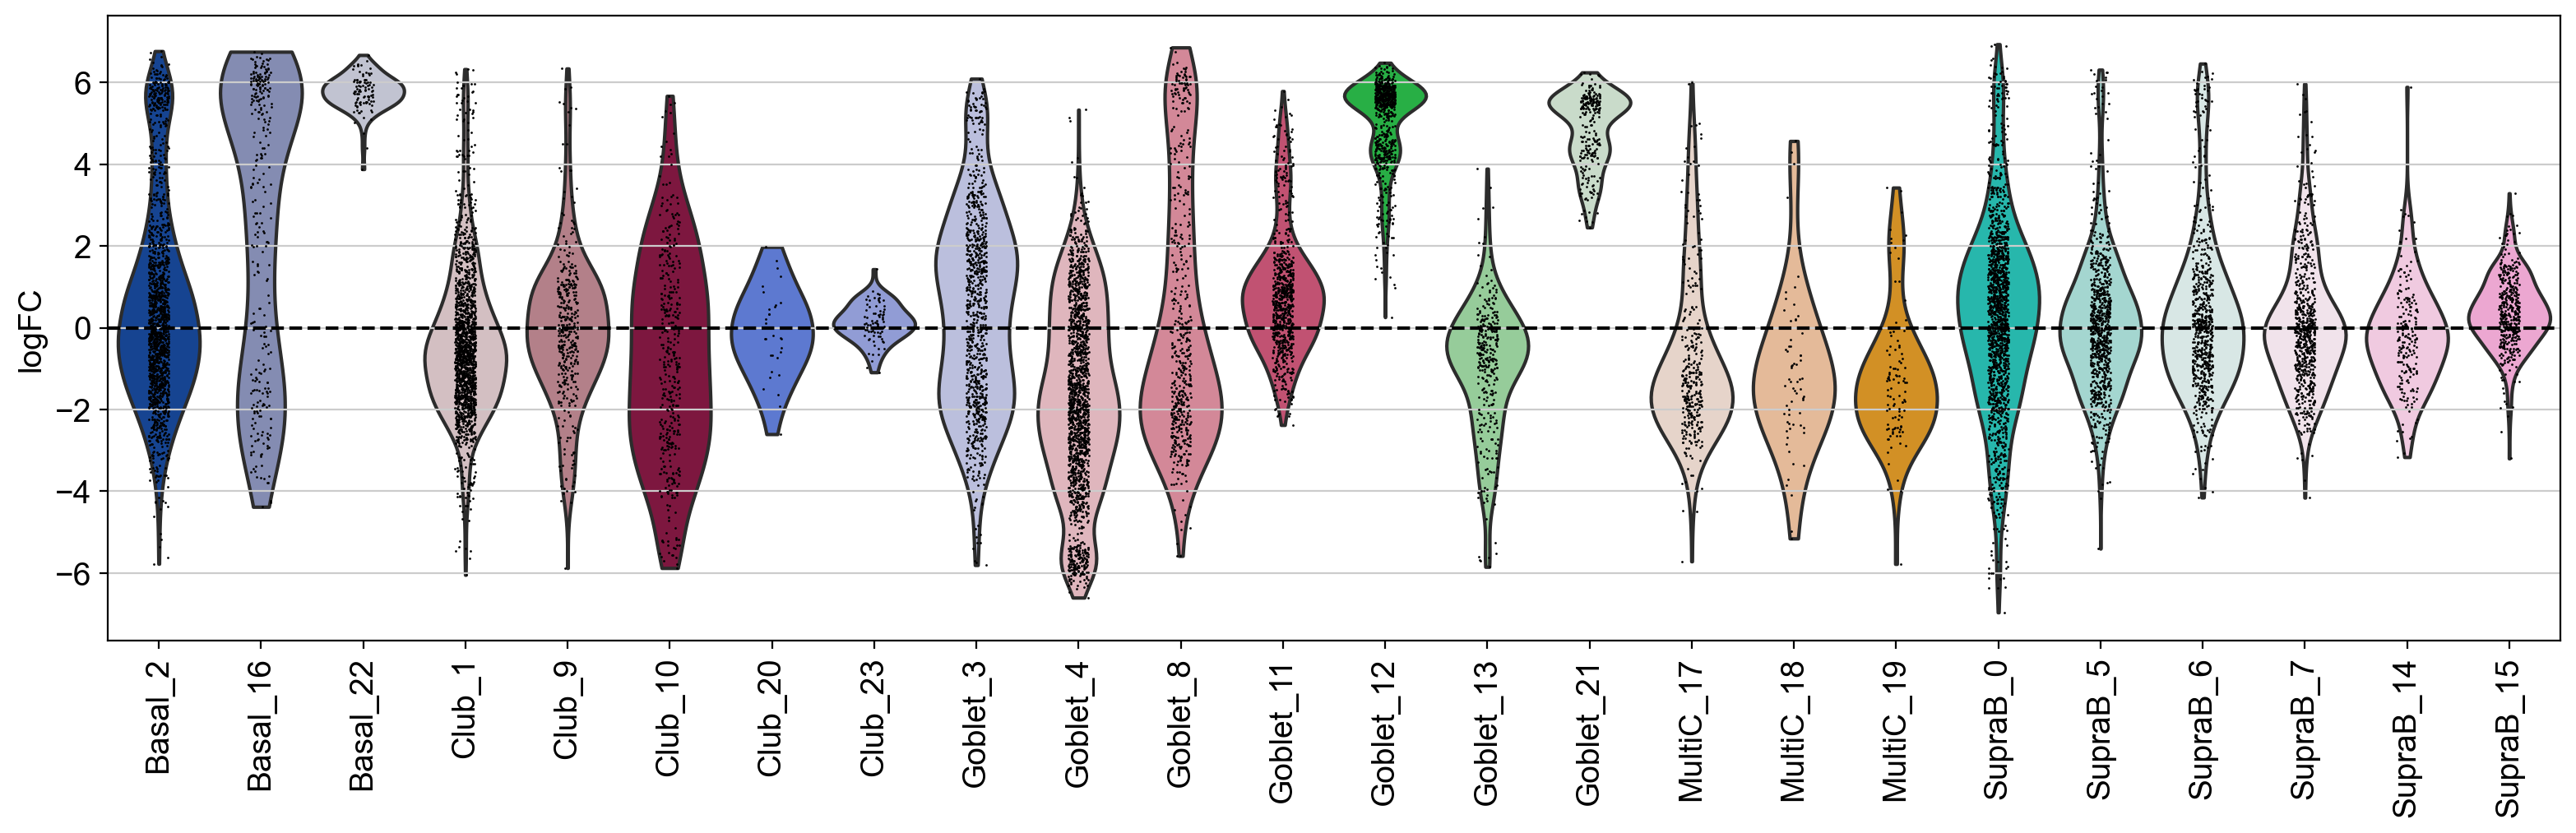

In [ ]:
# Plot violin plots for differential abundance results by cell type
sc.set_figure_params(figsize=(15, 5),dpi=100)
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False)
plt.axhline(y=0, color='black', linestyle='--')
plt.show()